# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 24

Group Members:
- Rajendra Farras Rayhan (18222105)
- Lina Azizah R. H. (18222107)
- Gracya Tio Damena Sidabutar (18222110)
- M. Kasyfil Aziz (18222127)

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from urllib.parse import urlparse
import ipaddress
import re

# Import other libraries if needed

## Import Dataset

In [3]:
# Example of reading a csv file from a gdrive link

# Take the file id from the gdrive file url
# https://drive.google.com/file/d/1ZUtiaty9RPXhpz5F2Sy3dFPHF4YIt5iU/view?usp=sharing => The file id is 1ZUtiaty9RPXhpz5F2Sy3dFPHF4YIt5iU
# and then put it in this format:
# https://drive.google.com/uc?id={file_id}
# Don't forget to change the access to public

df = pd.read_csv('https://drive.google.com/uc?id=1HMApjJesqeAiylfDkhz43vTpOndlmk9t')
df.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,...,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,...,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,...,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,...,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


In [4]:
# Ukuran data
instances, features = df.shape
print("The size of the data (instances and features).")
print(f"Instances: {instances}, Features: {features}\n")

The size of the data (instances and features).
Instances: 140404, Features: 56



# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [5]:
# Split the dataset into training and validation sets (80-20 split)
# Stratify ensures the label distribution is maintained across splits
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Display shapes and label distributions
print("Training Set:")
print(f"Shape: {train_set.shape}")
print(train_set['label'].value_counts(normalize=True))

print("\nValidation Set:")
print(f"Shape: {val_set.shape}")
print(val_set['label'].value_counts(normalize=True))

# # Save the splits to CSV if needed
# train_set.to_csv('train_split.csv', index=False)
# val_set.to_csv('val_split.csv', index=False)

Training Set:
Shape: (112323, 56)
label
1    0.924833
0    0.075167
Name: proportion, dtype: float64

Validation Set:
Shape: (28081, 56)
label
1    0.924825
0    0.075175
Name: proportion, dtype: float64


# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [6]:
# Menghitung jumlah nilai hilang di setiap kolom
print("Banyaknya missing data tiap fitur:")
missing_counts = df.isnull().sum()
print(missing_counts)
print("\n")

# Menghitung persentase nilai hilang di setiap kolom
print("Persentase missing data tiap fitur:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage)

Banyaknya missing data tiap fitur:
id                                0
FILENAME                      57532
URL                           43487
URLLength                     60639
Domain                        70197
DomainLength                  46319
IsDomainIP                    42130
TLD                           45399
CharContinuationRate          48042
TLDLegitimateProb             52873
URLCharProb                   52071
TLDLength                     47731
NoOfSubDomain                 44060
HasObfuscation                65720
NoOfObfuscatedChar            66798
ObfuscationRatio              64598
NoOfLettersInURL              63338
LetterRatioInURL              65746
NoOfDegitsInURL               58810
DegitRatioInURL               53508
NoOfEqualsInURL               61578
NoOfQMarkInURL                44101
NoOfAmpersandInURL            45387
NoOfOtherSpecialCharsInURL    47629
SpacialCharRatioInURL         62834
IsHTTPS                       49362
LineOfCode                   

# 1. FILENAME

In [7]:
# Hitung jumlah nilai unik di kolom FILENAME
unique_filenames = df['FILENAME'].nunique()
print(f"Jumlah nilai unik di kolom FILENAME: {unique_filenames}")

missing_filename_count = df['FILENAME'].isnull().sum()
total_data = unique_filenames + missing_filename_count
print(f"{unique_filenames} + {missing_filename_count} = {total_data}")
if(total_data == instances):
    print("SAMA")
else:
    print("BEDA")

Jumlah nilai unik di kolom FILENAME: 82872
82872 + 57532 = 140404
SAMA


Membuktikan semua filename itu unik semua. Persentase missing value cukup besar dan fitur ini hanya menambah kompleksitas tanpa ada signifikansi terhadap label, sehingga langkah terbaik untuk dilakukan terhadap FILENAME adalah
**Feature Deletion**

In [8]:
# Menghapus kolom FILENAME
train_set = train_set.drop(columns=['FILENAME'])
val_set = val_set.drop(columns=['FILENAME'])

# 2. URL

In [9]:
# Mengisi missing value pada URL menjadi "unknown"
train_set['URL'] = train_set['URL'].fillna('unknown')
val_set['URL'] = val_set['URL'].fillna('unknown')

# Fungsi untuk merekonstruksi URL berdasarkan kolom IsHTTPS dan Domain
def reconstruct_url(row):
    if row['URL'] == 'unknown' and pd.notnull(row['Domain']):  # Jika URL unknown dan Domain tersedia
        protocol = 'https' if row['IsHTTPS'] == 1 else 'http'  # Tentukan protokol berdasarkan IsHTTPS
        return f"{protocol}://{row['Domain']}"
    return row['URL']  # Jika URL sudah ada, biarkan

# Terapkan fungsi pada dataset
train_set['URL'] = train_set.apply(reconstruct_url, axis=1)
val_set['URL'] = val_set.apply(reconstruct_url, axis=1)

Oleh karena pada dataset memiliki fitur Domain dan IsHTTPS, kita bisa melakukan rekonstruksi untuk mengisi missing value dengan data yang sudah ada, namun jika memang tidak bisa terlacak dari Domain dan IsHTTPS maka akan tetap diisi dengan 'unknown'. Teknik ini menggunakan metode **Domain Knowledge**

# 3. URLLength

In [10]:
# Mengisi nilai missing pada URLLength berdasarkan kondisi URL
def fill_url_length(row):
    if pd.isnull(row['URLLength']):  # Jika URLLength bernilai NaN
        if row['URL'] == 'unknown':  # Jika URL bernilai 'unknown'
            return 0  # Isi dengan 0
        else:  # Jika URL tidak bernilai 'unknown'
            return len(row['URL'])  # Hitung panjang string URL
    else:
        return row['URLLength']  # Biarkan nilai asli jika tidak NaN

# Terapkan fungsi pada dataset
train_set['URLLength'] = train_set.apply(fill_url_length, axis=1)
val_set['URLLength'] = val_set.apply(fill_url_length, axis=1)

Untuk mengisi missing data URLLength dapat dilakukan dengan mengambil referensi dari fitur URL. Metode yang digunakan adalah **Domain Knowledge**

# 4. Domain

In [11]:
def fill_domain(row):
    if pd.isnull(row['Domain']):  # Jika Domain kosong
        if row['URL'] != 'unknown':  # Jika URL tersedia
            # Parse URL dan ambil domain/path pertama
            parsed_url = urlparse(row['URL'])
            domain = parsed_url.netloc.split(':')[0]  # Ambil domain tanpa port
            return domain
        else:
            # Jika URL juga unknown, isi Domain dengan 'unknown'
            return 'unknown'
    return row['Domain']  # Biarkan nilai asli jika Domain sudah terisi

# Terapkan fungsi pada dataset
train_set['Domain'] = train_set.apply(fill_domain, axis=1)
val_set['Domain'] = val_set.apply(fill_domain, axis=1)

Data domain yang masih missing bisa diisi dengan domain dari kolom URL, namun jika URL bernilai 'unknown' maka domain juga diisi 'unknown'. Metode yang digunakan adalah **Domain Knowledge**

# 5. DomainLength

In [12]:
# Fungsi untuk mengisi nilai DomainLength
def fill_domain_length(row):
    if pd.isnull(row['DomainLength']):  # Jika DomainLength kosong
        if row['Domain'] == 'unknown':  # Jika Domain bernilai 'unknown'
            return 0  # Isi dengan 0
        else:  # Jika Domain tersedia
            return len(row['Domain'])  # Hitung panjang Domain
    return row['DomainLength']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi pada dataset
train_set['DomainLength'] = train_set.apply(fill_domain_length, axis=1)
val_set['DomainLength'] = val_set.apply(fill_domain_length, axis=1)

Data domain length diambil dari kolom Domain, kalau Domainnya 'unknown', maka akan diisi 0. Metode yang digunakan adalah **Domain Knowledge**.

# 6. IsDomainIP

In [13]:
# Fungsi untuk memeriksa apakah domain adalah alamat IP
def is_ip_address(domain):
    try:
        ipaddress.ip_address(domain)  # Coba parsing domain sebagai IP
        return 1  # Jika berhasil, itu adalah alamat IP
    except ValueError:
        return 0  # Jika gagal, itu bukan alamat IP

# Fungsi untuk mengisi nilai IsDomainIP
def fill_is_domain_ip(row):
    if pd.isnull(row['IsDomainIP']):  # Jika IsDomainIP kosong
        if row['Domain'] == 'unknown':  # Jika Domain 'unknown'
            return 0  # Isi dengan 0 (bukan alamat IP)
        else:
            return is_ip_address(row['Domain'])  # Periksa apakah Domain adalah alamat IP
    return row['IsDomainIP']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi pada dataset
train_set['IsDomainIP'] = train_set.apply(fill_is_domain_ip, axis=1)
val_set['IsDomainIP'] = val_set.apply(fill_is_domain_ip, axis=1)

Untuk mengetahui suatu Domain itu alamat IP atau bukan, akan digunakan fungsi is_ip_address dengan library ipaddress. Jika Domain bernilai 'unknown' akan diisi nilai 0. Metode yang digunakan adalah **Domain Knowledge**.

# 7. TLD

In [14]:
# Fungsi untuk mengisi nilai TLD
def fill_tld(row):
    if pd.isnull(row['TLD']):  # Jika TLD kosong
        if row['Domain'] == 'unknown':  # Jika Domain 'unknown'
            return 'unknown'  # Isi TLD dengan 'unknown'
        elif is_ip_address(row['Domain']):  # Jika Domain adalah alamat IP
            return row['Domain'].split('.')[-1]  # Ambil bagian terakhir dari IP sebagai TLD
        else:  # Jika Domain adalah domain valid
            parts = row['Domain'].split('.')
            return parts[-1] if len(parts) > 1 else 'unknown'  # Ambil bagian terakhir sebagai TLD
    return row['TLD']  # Biarkan nilai asli jika TLD sudah terisi

# Terapkan fungsi pada dataset
train_set['TLD'] = train_set.apply(fill_tld, axis=1)
val_set['TLD'] = val_set.apply(fill_tld, axis=1)

Untuk mengisi missing value TLD dapat diambil dari bagian terakhir dari Domain, jika Domain bernilai 'unknown' maka TLD juga akan diisi 'unknown'. Metode yang digunakan adalah **Domain Knowledge**.

# 8. CharContinuationRate

In [15]:
# Fungsi untuk mengisi nilai CharContinuationRate
def fill_char_continuation_rate(row):
    if pd.isnull(row['CharContinuationRate']):  # Jika CharContinuationRate kosong
        if pd.isnull(row['Domain']) or row['Domain'] == 'unknown':  # Jika Domain kosong atau 'unknown'
            return 0  # Isi dengan 0 jika domain tidak valid
        else:
            domain_main = row['Domain']
            # Abaikan 'www.' jika ada di awal domain
            if domain_main.startswith('www.'):
                domain_main = domain_main[4:]  # Hapus 'www.'

            # Abaikan TLD di akhir domain
            if '.' in domain_main:
                domain_main = domain_main.rsplit('.', 1)[0]
            # print(f"com ilang: {domain_main}")

            # Pisahkan berdasarkan karakter kontinuiti
            if '-' not in domain_main and '_' not in domain_main and '.' not in domain_main:
                return 1.0  # Jika tidak ada karakter pemisah, langsung nilai 1

            # Pisahkan berdasarkan karakter kontinuiti secara bersamaan
            segments = re.split('[-_.]', domain_main)  # Pisahkan berdasarkan '-', '_', dan '.'

            # Hitung segmen terpanjang
            longest_segment = max(len(segment) for segment in segments)
            total_length = len(domain_main)  # Panjang total string yang dianalisis

            # Rumus CharContinuationRate
            return (longest_segment + 1) / total_length if total_length > 0 else 0
    return row['CharContinuationRate']  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi pada dataset
train_set['CharContinuationRate'] = train_set.apply(fill_char_continuation_rate, axis=1)
val_set['CharContinuationRate'] = val_set.apply(fill_char_continuation_rate, axis=1)

Untuk mengisi CharContinuationRate dapat ditemukan pola bahwa string terpanjang dari setiap segmen domain itu ditambah satu lalu dibagi total panjang string. Jika domain bernilai 'unknown' maka akan diisi dengan 0. Metode yang digunakan adalah **Domain Knowledge**.

# 9. TLDLegitimateProb

In [16]:
# Hitung rata-rata TLDLegitimateProb berdasarkan TLD hanya di training set
tld_prob_mean_train = train_set.groupby('TLD')['TLDLegitimateProb'].mean()

# Rata-rata global untuk fallback dari training set
global_mean_tld_prob_train = train_set['TLDLegitimateProb'].mean()

# Fungsi untuk mengisi TLDLegitimateProb menggunakan rata-rata dari training set
def fill_tld_legitimate_prob_separated(row, tld_prob_mean, global_mean):
    if pd.isnull(row['TLDLegitimateProb']):  # Jika TLDLegitimateProb kosong
        if row['TLD'] == 'unknown':  # Jika TLD adalah 'unknown'
            return 0  # Isi dengan 0
        elif row['TLD'] in tld_prob_mean and not pd.isnull(tld_prob_mean[row['TLD']]):  # Jika TLD memiliki rata-rata
            return tld_prob_mean[row['TLD']]  # Isi dengan rata-rata TLD dari training set
        elif row['TLD'] in tld_prob_mean and pd.isnull(tld_prob_mean[row['TLD']]):  # Jika TLD ada tapi rata-rata null
            return global_mean  # Isi dengan rata-rata global dari training set
        else:
            return global_mean  # Fallback jika semua kondisi gagal
    return row['TLDLegitimateProb']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi untuk training set
train_set['TLDLegitimateProb'] = train_set.apply(
    fill_tld_legitimate_prob_separated, axis=1,
    tld_prob_mean=tld_prob_mean_train, global_mean=global_mean_tld_prob_train
)

# Terapkan fungsi untuk validation set
val_set['TLDLegitimateProb'] = val_set.apply(
    fill_tld_legitimate_prob_separated, axis=1,
    tld_prob_mean=tld_prob_mean_train, global_mean=global_mean_tld_prob_train
)

Untuk mengisi TLDLegitimateProb dapat dilakukan dengan groupby TLD dengan nilai rata-rata dari TLDLegitimateProb, sehingga jika bertemu dengan TLDLengthProb yang null tapi memiliki TLD yang sudah ada pada data groupby, nilainya akan sama dengan rata-rata TLDLegitimateProb itu. Namun jika TLD itu tidak memiliki rata-rata, maka akan diisi dengan nilai rata-rata keseluruhan TLDLegitimateProb. Jika TLD bernilai unknown maka akan diisi nilai 0. Metode yang digunakan adalah **Domain Knowledge** dan **Mean Imputation**.

# 10. URLCharProb

In [17]:
# Hitung median dari URLCharProb di training set
median_url_char_prob_train = train_set['URLCharProb'].median()

# Fungsi untuk mengisi nilai menggunakan median dari training set
def fill_url_char_prob(value, median_value):
    if pd.isnull(value):  # Jika nilai kosong
        return median_value  # Isi dengan median dari training set
    return value  # Biarkan nilai asli jika tidak kosong

# Terapkan median imputasi untuk training set
train_set['URLCharProb'] = train_set['URLCharProb'].apply(
    fill_url_char_prob, median_value=median_url_char_prob_train
)

# Terapkan median imputasi untuk validation set menggunakan median dari training set
val_set['URLCharProb'] = val_set['URLCharProb'].apply(
    fill_url_char_prob, median_value=median_url_char_prob_train
)

In [18]:
train_set['TLDLength'] = train_set.apply(
    lambda row: 0 if pd.isnull(row['TLDLength']) and row['TLD'] == 'unknown' else (
        len(row['TLD']) if pd.isnull(row['TLDLength']) and row['TLD'] != 'unknown' else row['TLDLength']
    ),
    axis=1
)

val_set['TLDLength'] = val_set.apply(
    lambda row: 0 if pd.isnull(row['TLDLength']) and row['TLD'] == 'unknown' else (
        len(row['TLD']) if pd.isnull(row['TLDLength']) and row['TLD'] != 'unknown' else row['TLDLength']
    ),
    axis=1
)

In [19]:
# Fungsi untuk mengisi missing value pada NoOfSubDomain
def fill_no_of_subdomain(row):
    if pd.isnull(row['NoOfSubDomain']):  # Jika NoOfSubDomain kosong
        if pd.isnull(row['Domain']) or row['Domain'] == 'unknown':  # Jika Domain kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            domain_parts = row['Domain'].split('.')  # Pisahkan domain berdasarkan '.'
            return max(len(domain_parts) - 2, 0)  # Kurangi 2 untuk TLD dan domain utama
    return row['NoOfSubDomain']  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi untuk mengisi missing data pada NoOfSubDomain
train_set['NoOfSubDomain'] = train_set.apply(fill_no_of_subdomain, axis=1)
val_set['NoOfSubDomain'] = val_set.apply(fill_no_of_subdomain, axis=1)

In [20]:
# Fungsi untuk mengisi missing value pada NoOfLettersInURL
def fill_no_of_letters_in_url(row):
    if pd.isnull(row['NoOfLettersInURL']):  # Jika NoOfLettersInURL kosong
        if pd.isnull(row['URL']) or row['URL'] == 'unknown':  # Jika URL kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            # Hitung jumlah huruf dalam URL (hanya karakter alfabet)
            return sum(char.isalpha() for char in row['URL'])
    return row['NoOfLettersInURL']  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi untuk mengisi missing data pada NoOfLettersInURL
train_set['NoOfLettersInURL'] = train_set.apply(fill_no_of_letters_in_url, axis=1)
val_set['NoOfLettersInURL'] = val_set.apply(fill_no_of_letters_in_url, axis=1)

In [21]:
# Fungsi untuk mengisi missing value pada LetterRatioInURL
def fill_letter_ratio_in_url(row):
    if pd.isnull(row['LetterRatioInURL']):  # Jika LetterRatioInURL kosong
        if pd.isnull(row['URL']) or row['URL'] == 'unknown':  # Jika URL kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            url_length = len(row['URL'])  # Panjang URL
            no_of_letters = row['NoOfLettersInURL']  # Jumlah huruf dalam URL
            return no_of_letters / url_length if url_length > 0 else 0  # Hitung rasio
    return row['LetterRatioInURL']  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi untuk mengisi missing data pada LetterRatioInURL
train_set['LetterRatioInURL'] = train_set.apply(fill_letter_ratio_in_url, axis=1)
val_set['LetterRatioInURL'] = val_set.apply(fill_letter_ratio_in_url, axis=1)

In [22]:
# Fungsi untuk mengisi missing value pada NoOfDegitsInURL
def fill_no_of_digits_in_url(row):
    if pd.isnull(row['NoOfDegitsInURL']):  # Jika NoOfDegitsInURL kosong
        if pd.isnull(row['URL']) or row['URL'] == 'unknown':  # Jika URL kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            # Hitung jumlah digit dalam URL
            return sum(char.isdigit() for char in row['URL'])
    return row['NoOfDegitsInURL']  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi untuk mengisi missing data pada NoOfDegitsInURL
train_set['NoOfDegitsInURL'] = train_set.apply(fill_no_of_digits_in_url, axis=1)
val_set['NoOfDegitsInURL'] = val_set.apply(fill_no_of_digits_in_url, axis=1)

In [23]:
# Fungsi untuk mengisi missing value pada DegitRatioInURL
def fill_digit_ratio_in_url(row):
    if pd.isnull(row['DegitRatioInURL']):  # Jika DegitRatioInURL kosong
        if pd.isnull(row['URL']) or row['URL'] == 'unknown':  # Jika URL kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            url_length = len(row['URL'])  # Total panjang URL
            no_of_digits = row['NoOfDegitsInURL']  # Jumlah digit di URL
            return no_of_digits / url_length if url_length > 0 else 0  # hitung ratio
    return row['DegitRatioInURL']  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi untuk mengisi missing data pada DegitRatioInURL
train_set['DegitRatioInURL'] = train_set.apply(fill_digit_ratio_in_url, axis=1)
val_set['DegitRatioInURL'] = val_set.apply(fill_digit_ratio_in_url, axis=1)

In [24]:
def count_special_characters_in_url(row, column_name, target_chars=None):
    if pd.isnull(row[column_name]):  # Kalau kolom target bernilai null
        if row['URL'] == 'unknown':  # Kalau URL bernilai unknown
            return 0  # Set ke 0
        else:
            if target_chars is None:  # Jika target_chars tidak ditentukan
                # Gunakan daftar karakter spesial default
                target_chars = set("!@#$%^*()-_+[]{}|\\;:'\"<>,./")

            # Hitung kemunculan karakter spesifik di URL
            return sum(char in target_chars for char in row['URL'])
    return row[column_name]  # Biarkan nilai asli jika sudah terisi

# Terapkan fungsi untuk multiple columns dengan karakter berbeda
special_characters_columns = {
    'NoOfEqualsInURL': {'='},   # Count '='
    'NoOfQMarkInURL': {'?'},    # Count '?'
    'NoOfAmpersandInURL': {'&'},  # Count '&'
    'NoOfOtherSpecialCharsInURL': None, # Count karakter spesial lainnya
}

# Isi missing values tiap kolom
for column, chars in special_characters_columns.items():
    train_set[column] = train_set.apply(count_special_characters_in_url, axis=1, column_name=column, target_chars=chars)
    val_set[column] = val_set.apply(count_special_characters_in_url, axis=1, column_name=column, target_chars=chars)

In [25]:
# Fungsi untuk mengisi SpacialCharRatioInURL
def fill_spacial_char_ratio_from_columns(row):
    if pd.isnull(row['SpacialCharRatioInURL']):  # Jika SpacialCharRatioInURL kosong
        if pd.isnull(row['URL']) or row['URL'] == 'unknown':  # Jika URL kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            # Panjang total URL
            url_length = len(row['URL'])

            # Jumlah karakter spasial dari kolom terkait
            total_spacial_chars = (
                (row['NoOfAmpersandInURL'] if not pd.isnull(row['NoOfAmpersandInURL']) else 0) +
                (row['NoOfQMarkInURL'] if not pd.isnull(row['NoOfQMarkInURL']) else 0) +
                (row['NoOfEqualsInURL'] if not pd.isnull(row['NoOfEqualsInURL']) else 0) +
                (row['NoOfOtherSpecialCharsInURL'] if not pd.isnull(row['NoOfOtherSpecialCharsInURL']) else 0)
            )

            # Hitung rasio
            return total_spacial_chars / url_length if url_length > 0 else 0
    return row['SpacialCharRatioInURL']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi untuk mengisi SpacialCharRatioInURL
train_set['SpacialCharRatioInURL'] = train_set.apply(fill_spacial_char_ratio_from_columns, axis=1)
val_set['SpacialCharRatioInURL'] = val_set.apply(fill_spacial_char_ratio_from_columns, axis=1)

In [26]:
# Fungsi untuk mengisi IsHTTPS
def fill_is_https(row):
    if pd.isnull(row['IsHTTPS']):  # Jika IsHTTPS kosong
        if pd.isnull(row['URL']) or row['URL'] == 'unknown':  # Jika URL kosong atau 'unknown'
            return 0  # Isi dengan 0
        else:
            # Cek apakah URL dimulai dengan 'https://'
            return 1 if row['URL'].startswith('https://') else 0
    return row['IsHTTPS']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi untuk mengisi IsHTTPS
train_set['IsHTTPS'] = train_set.apply(fill_is_https, axis=1)
val_set['IsHTTPS'] = val_set.apply(fill_is_https, axis=1)

In [27]:
# Fungsi untuk mengisi missing value pada HasTitle
def fill_has_title(row):
    if pd.isnull(row['HasTitle']):  # Jika HasTitle kosong
        return 0 if pd.isnull(row['Title']) else 1  # Isi 0 jika Title kosong, 1 jika Title ada
    return row['HasTitle']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi untuk mengisi HasTitle
train_set['HasTitle'] = train_set.apply(fill_has_title, axis=1)
val_set['HasTitle'] = val_set.apply(fill_has_title, axis=1)

In [28]:
# Isi missing value pada kolom Title dengan "unknown"
train_set['Title'] = train_set['Title'].fillna('unknown')
val_set['Title'] = val_set['Title'].fillna('unknown')

In [29]:
# Fungsi untuk mengisi DomainTitleMatchScore
def fill_domain_title_match_score(row):
    if pd.isnull(row['DomainTitleMatchScore']):  # Jika DomainTitleMatchScore kosong
        if row['Domain'] == 'unknown' or row['Title'] == 'unknown':  # Jika salah satu unknown
            return 0  # Isi dengan 0

        # Bersihkan domain dari 'www.' dan TLD
        domain_cleaned = row['Domain']
        if domain_cleaned.startswith('www.'):
            domain_cleaned = domain_cleaned[4:]  # Hapus 'www.'
        domain_parts = domain_cleaned.split('.')  # Pisahkan domain pada tanda titik
        domain_without_tld = '.'.join(domain_parts[:-1])  # Hilangkan bagian TLD (bagian terakhir)

        # Periksa apakah Title adalah substring dari domain yang bersih
        if row['Title'] in domain_without_tld:
            return 100  # Cocok
        else:
            return 0  # Tidak cocok
    return row['DomainTitleMatchScore']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi untuk mengisi DomainTitleMatchScore
train_set['DomainTitleMatchScore'] = train_set.apply(fill_domain_title_match_score, axis=1)
val_set['DomainTitleMatchScore'] = val_set.apply(fill_domain_title_match_score, axis=1)

In [30]:
# Fungsi untuk mengisi URLTitleMatchScore
def fill_url_title_match_score(row):
    if pd.isnull(row['URLTitleMatchScore']):  # Jika URLTitleMatchScore kosong
        if row['URL'] == 'unknown' or pd.isnull(row['URL']) or row['Title'] == 'unknown' or pd.isnull(row['Title']):
            return 0  # Isi dengan 0 jika URL atau Title tidak valid

        # Bersihkan URL dari protokol (http:// atau https://)
        url_cleaned = row['URL']
        if url_cleaned.startswith('http://'):
            url_cleaned = url_cleaned[7:]
        elif url_cleaned.startswith('https://'):
            url_cleaned = url_cleaned[8:]

        # Periksa apakah Title ada di dalam URL (case-insensitive)
        if row['Title'].lower() in url_cleaned.lower():
            return 100  # Cocok
        else:
            return 0  # Tidak cocok
    return row['URLTitleMatchScore']  # Biarkan nilai asli jika sudah ada

# Terapkan fungsi untuk mengisi URLTitleMatchScore
train_set['URLTitleMatchScore'] = train_set.apply(fill_url_title_match_score, axis=1)
val_set['URLTitleMatchScore'] = val_set.apply(fill_url_title_match_score, axis=1)

In [31]:
# Fungsi untuk mengisi missing value menggunakan modus untuk banyak kolom
def fill_missing_with_modus(df, columns, train_mode):
    for column in columns:
        mode_value = train_mode[column]  # Assign modus dari training set
        df[column] = df[column].fillna(mode_value)  # Isi missing value dengan modus
    return df

# Daftar kolom yang ingin diisi missing value-nya menggunakan modus
sisa_kolom = ['HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'LineOfCode', 'LargestLineLength', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']

# Hitung modus dari sisa kolom pada training set
train_mode_values = {column: train_set[column].mode()[0] for column in sisa_kolom if column in train_set.columns}

# Terapkan imputasi pada training set
train_set = fill_missing_with_modus(train_set, sisa_kolom, train_mode_values)

# Terapkan imputasi pada validation set menggunakan modus dari training set
val_set = fill_missing_with_modus(val_set, sisa_kolom, train_mode_values)

In [32]:
# Cetak jumlah nilai null pada setiap kolom di train_set
print("Jumlah nilai null pada setiap kolom di train_set:")
print(train_set.isnull().sum())

# Cetak jumlah nilai null pada setiap kolom di val_set
print("\nJumlah nilai null pada setiap kolom di val_set:")
print(val_set.isnull().sum())

Jumlah nilai null pada setiap kolom di train_set:
id                            0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore 

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [33]:
print(df.describe())

                  id     URLLength  DomainLength    IsDomainIP  \
count  140404.000000  79765.000000  94085.000000  98274.000000   
mean   117682.632746     27.701473     19.619387      0.000488   
std     68122.005080     23.140676      5.833808      0.022095   
min         1.000000     14.000000      4.000000      0.000000   
25%     58689.500000     23.000000     16.000000      0.000000   
50%    117421.500000     26.000000     19.000000      0.000000   
75%    176724.250000     30.000000     23.000000      0.000000   
max    235795.000000   4054.000000     93.000000      1.000000   

       CharContinuationRate  TLDLegitimateProb   URLCharProb     TLDLength  \
count          92362.000000       87531.000000  88333.000000  92673.000000   
mean               0.918007           0.277482      0.059286      2.729015   
std                0.159142           0.248115      0.008063      0.533310   
min                0.000000           0.000000      0.001229      2.000000   
25%            

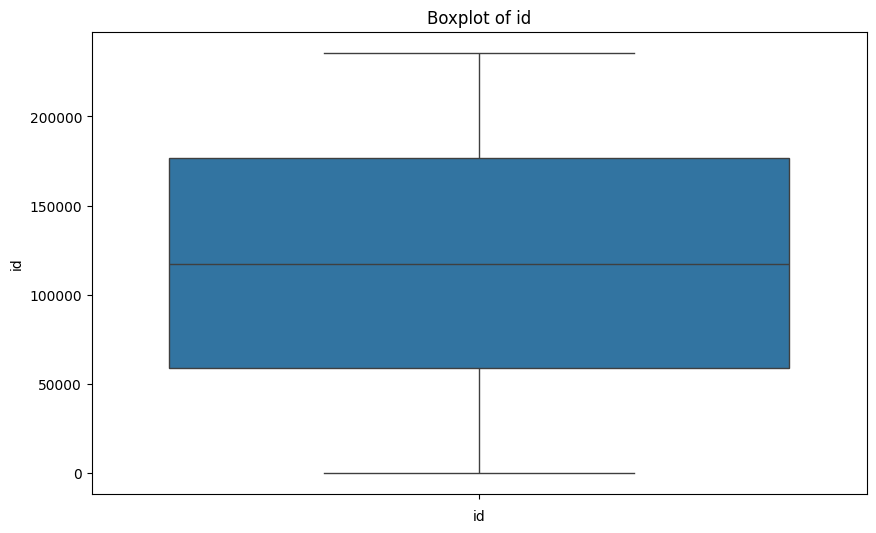

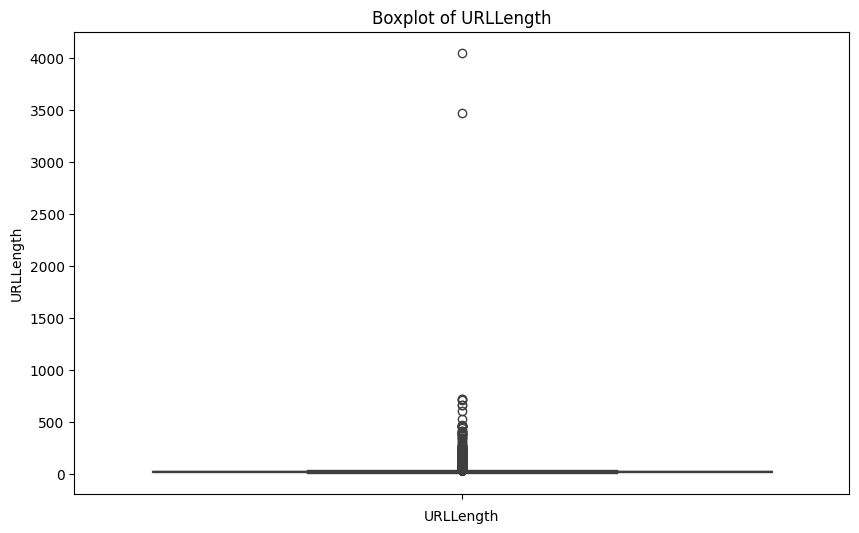

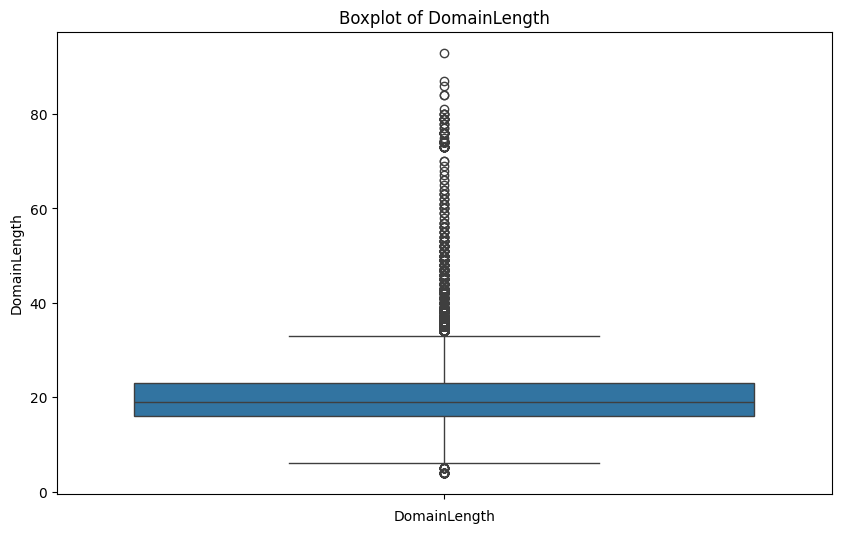

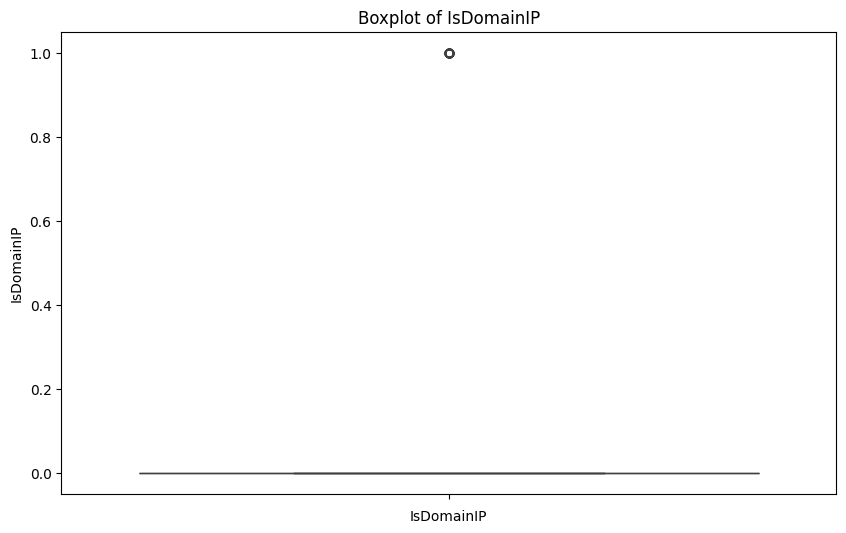

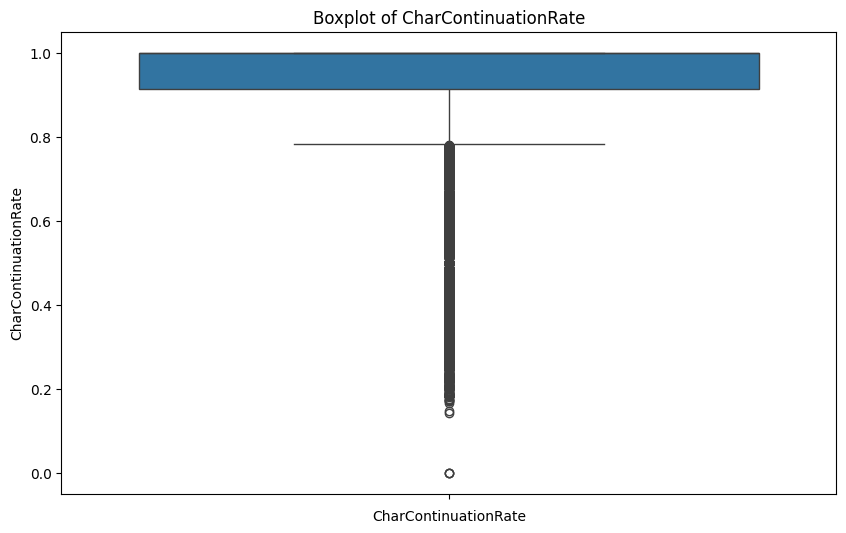

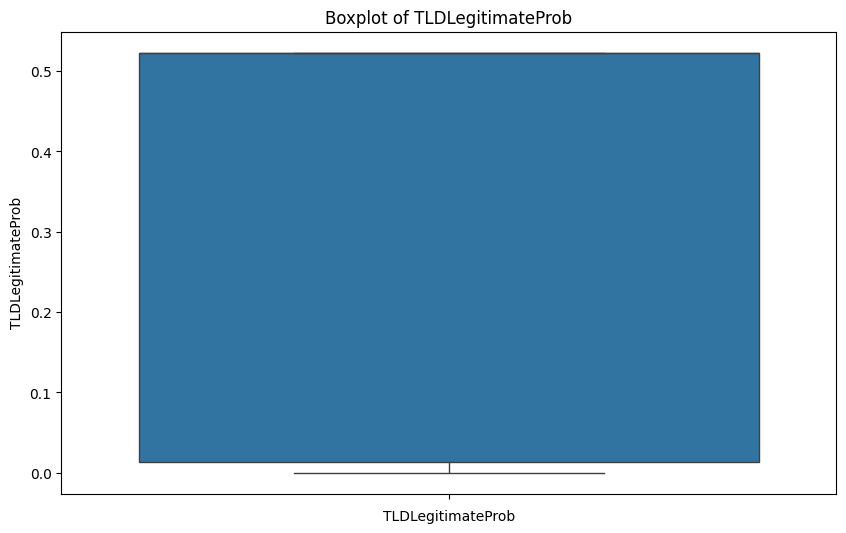

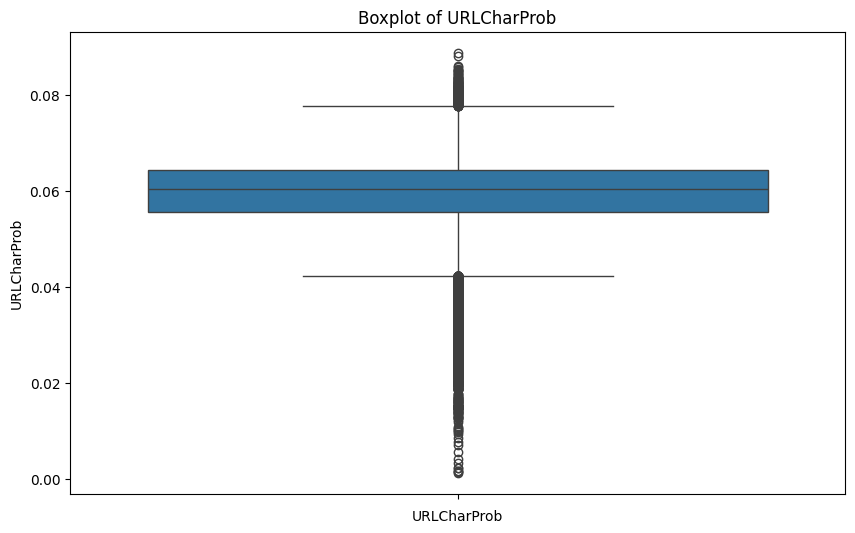

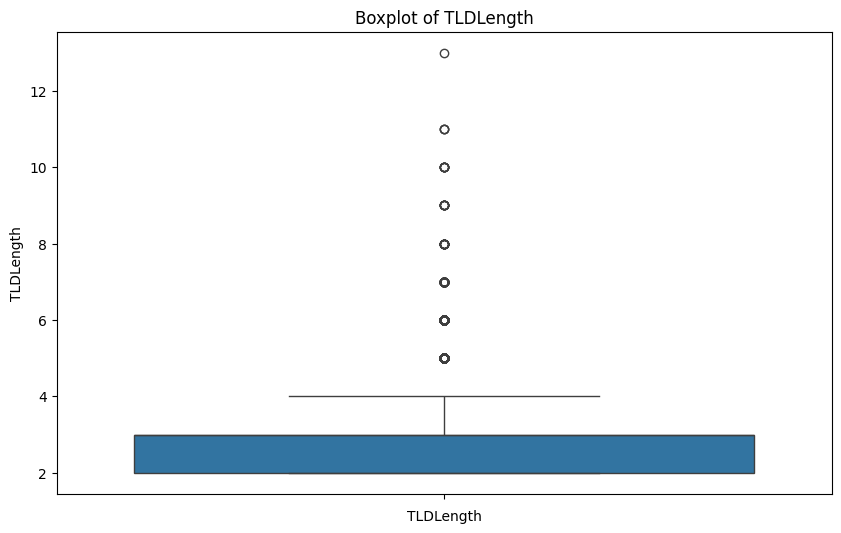

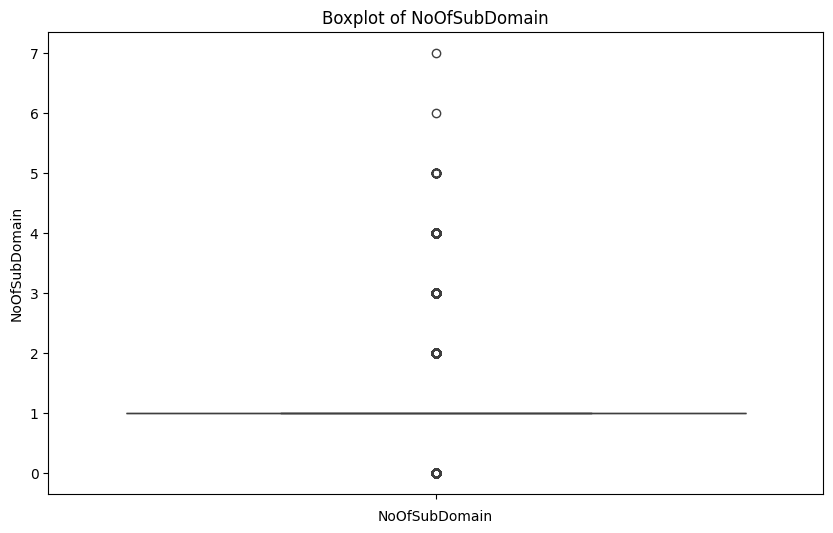

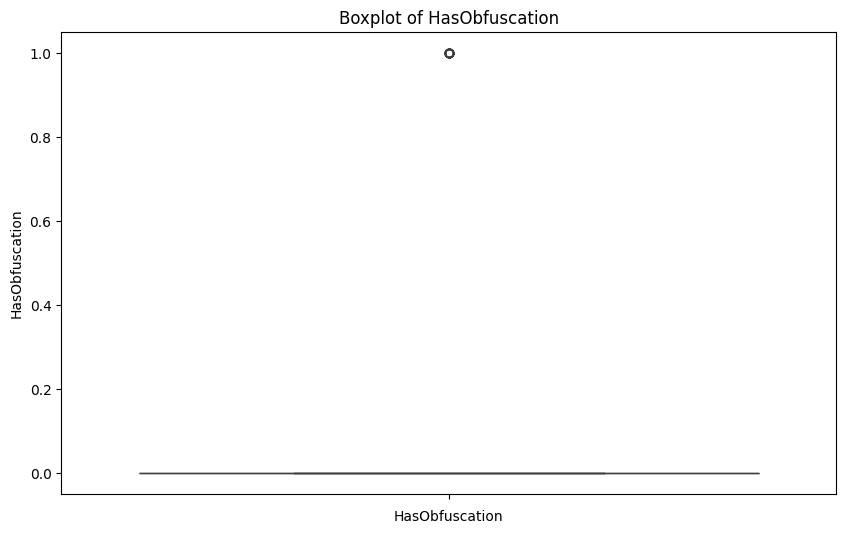

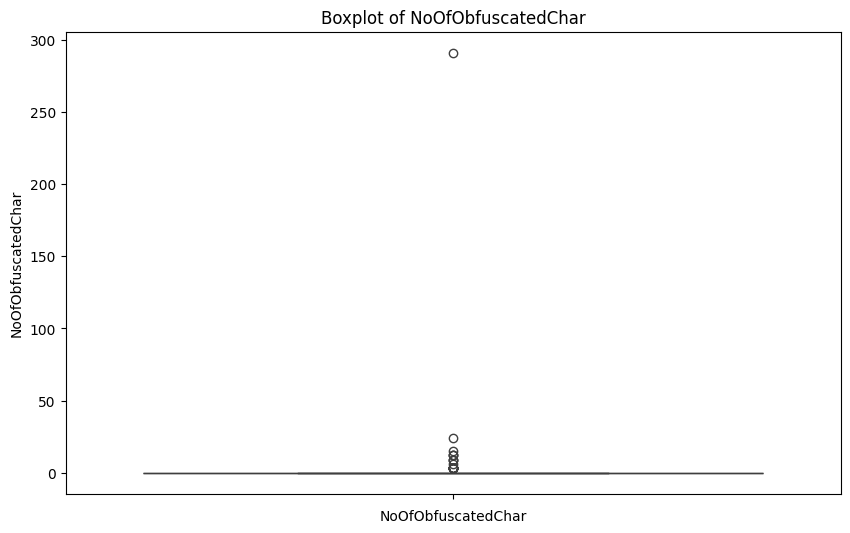

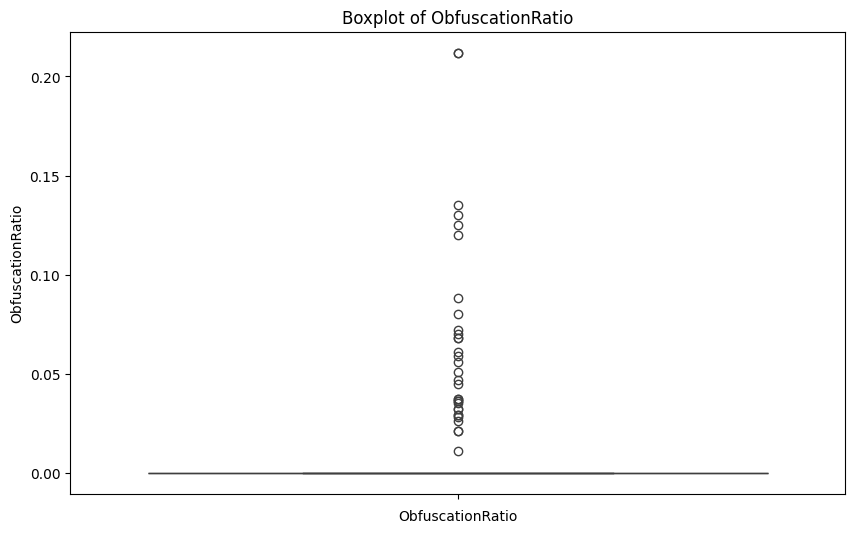

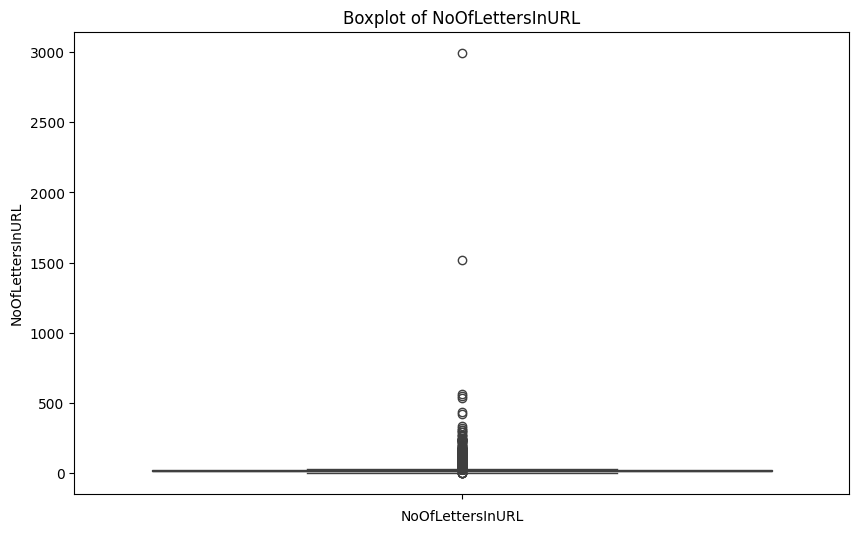

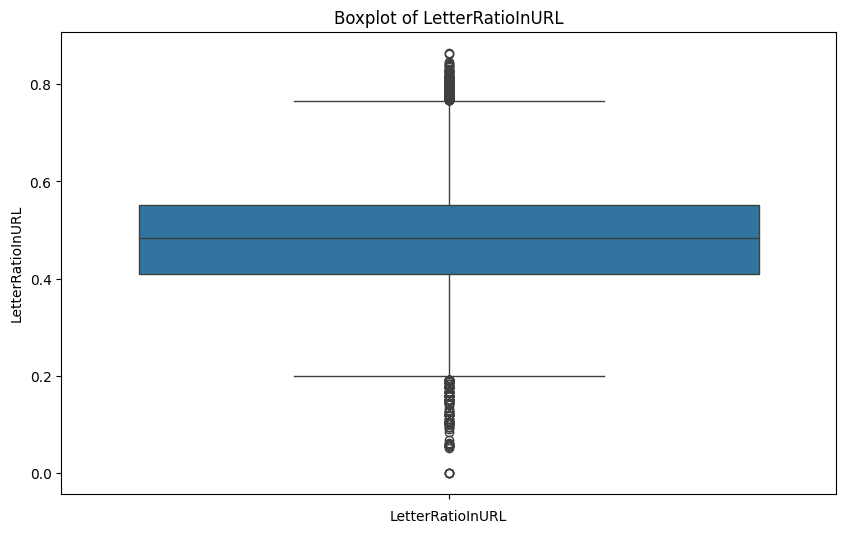

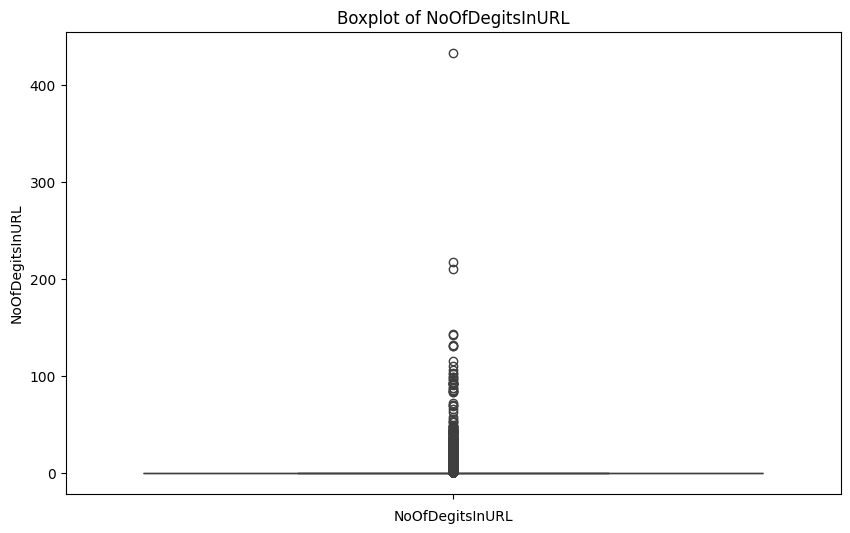

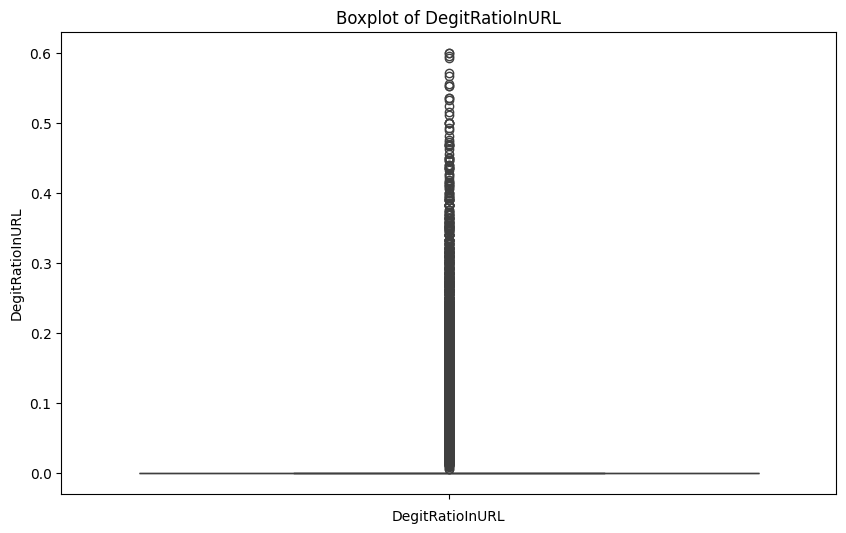

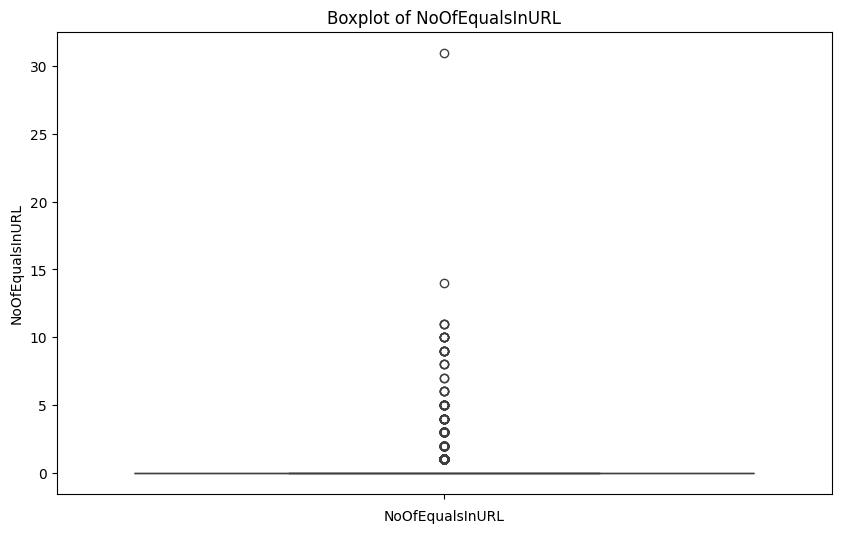

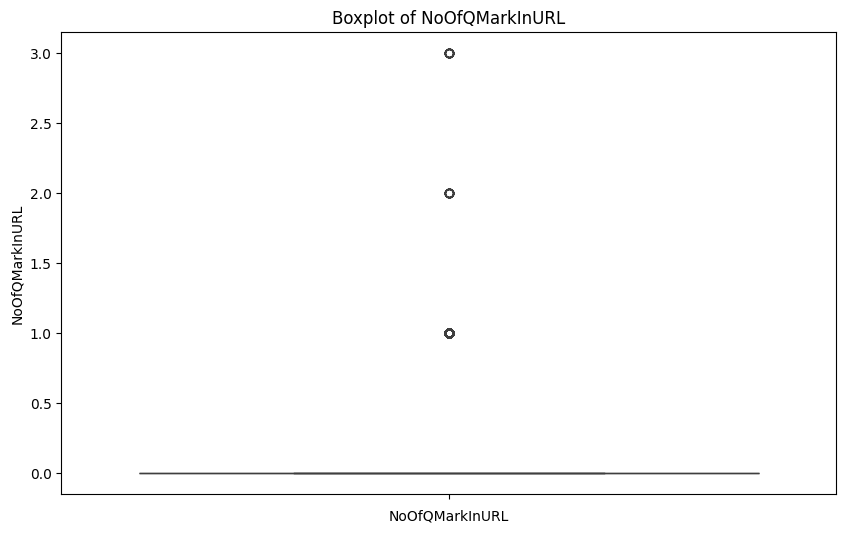

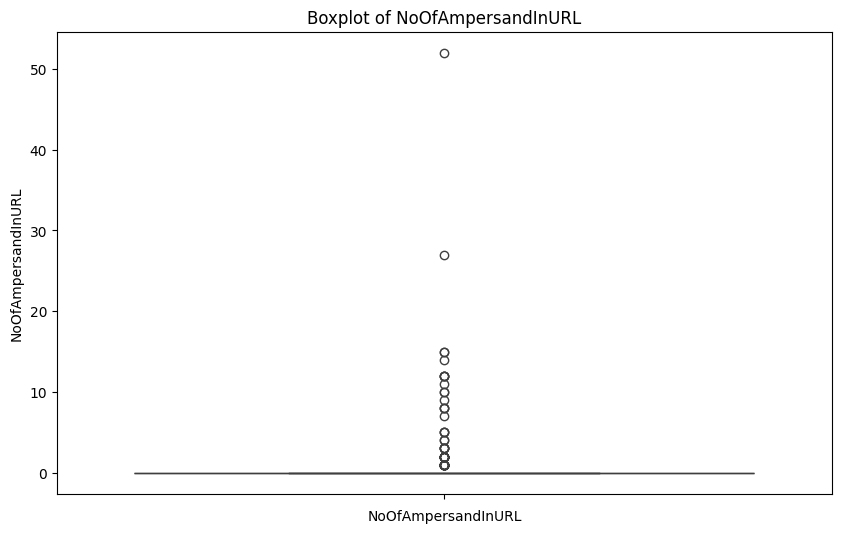

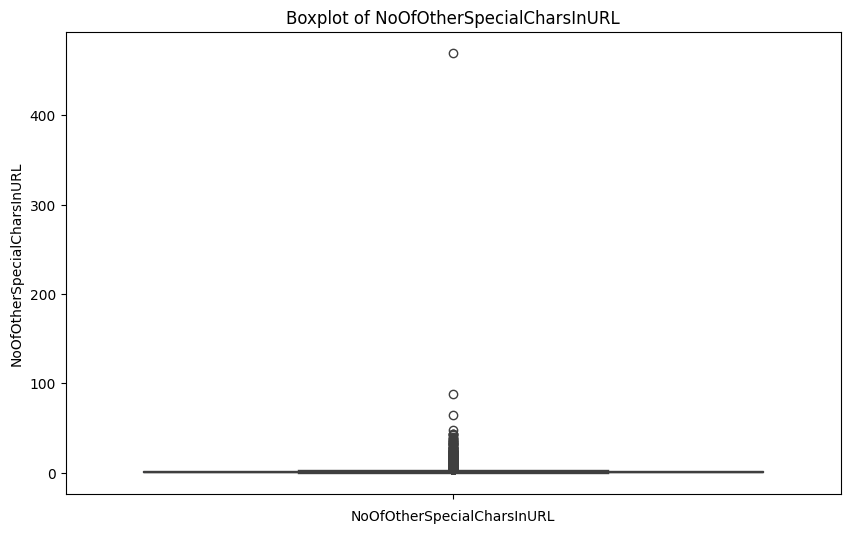

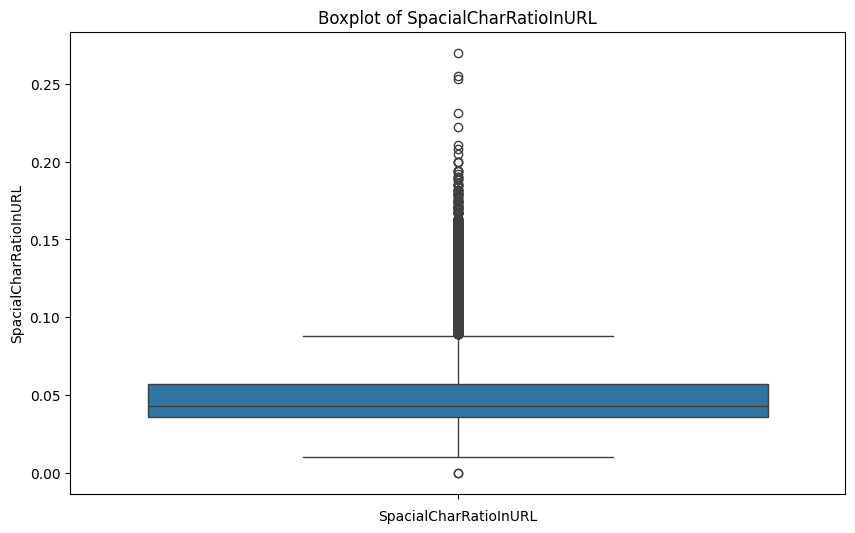

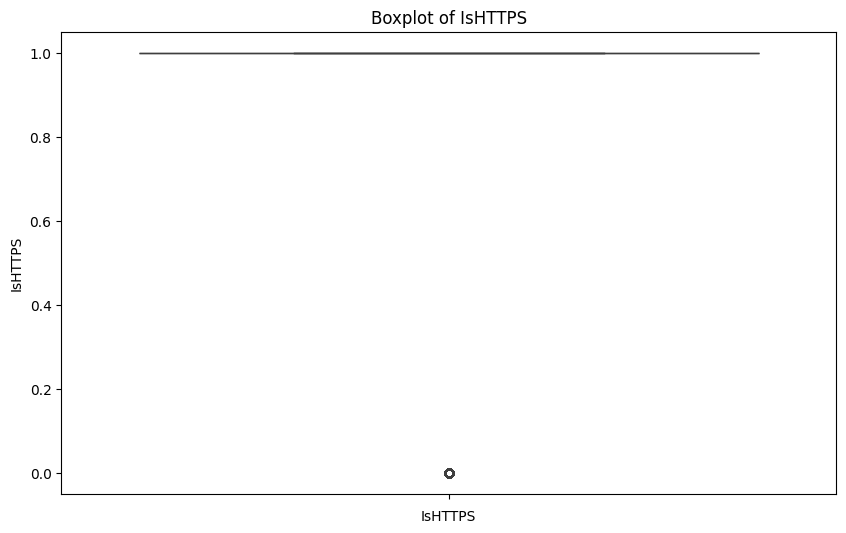

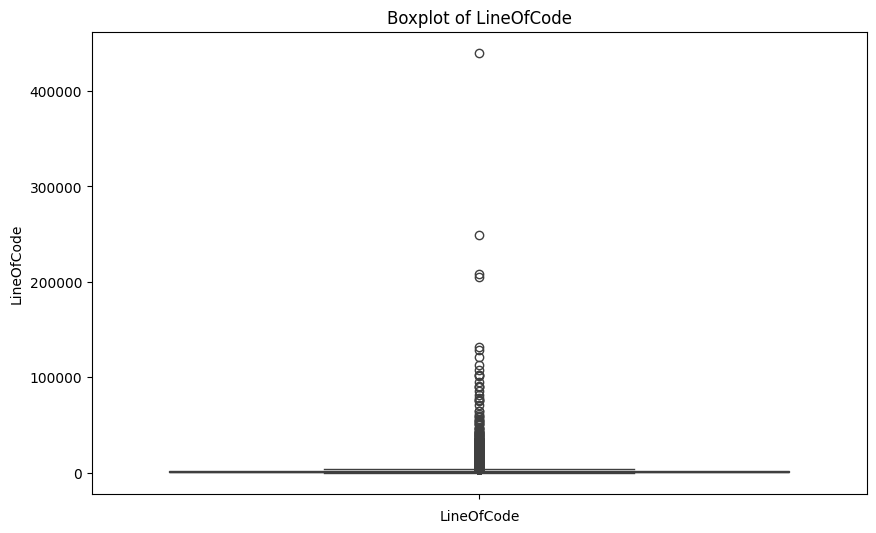

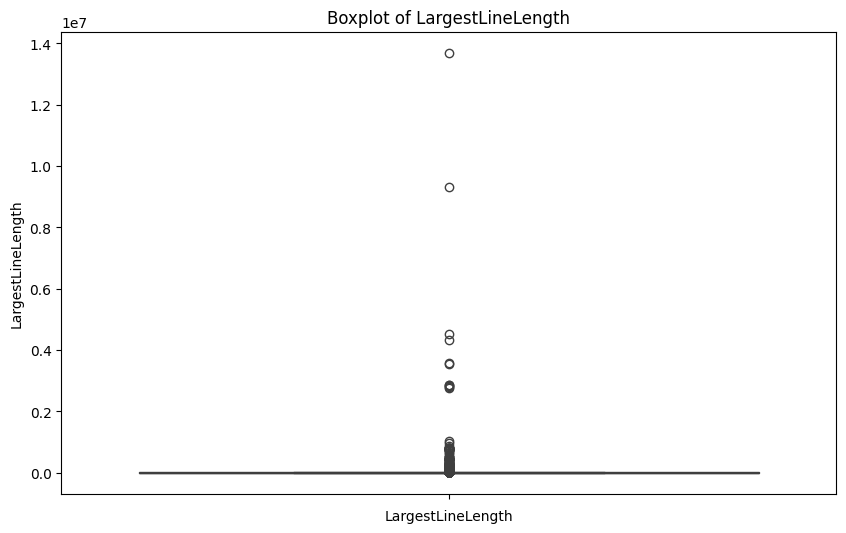

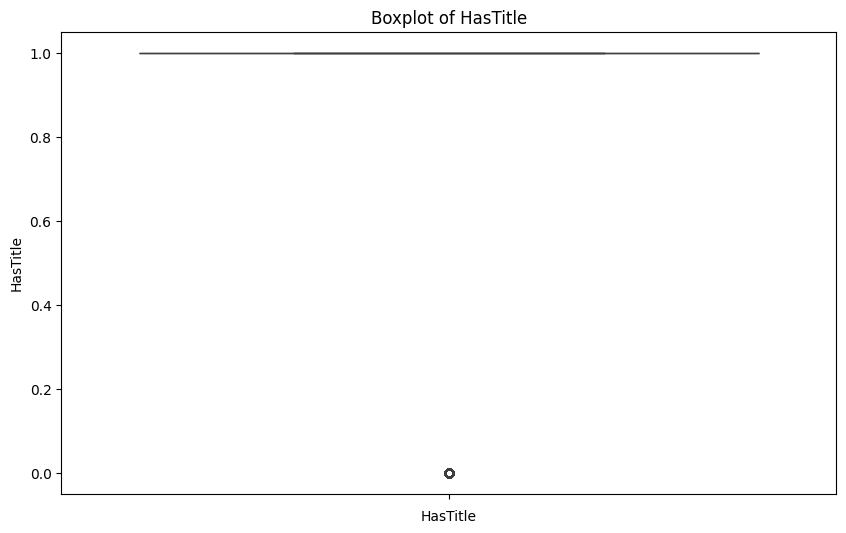

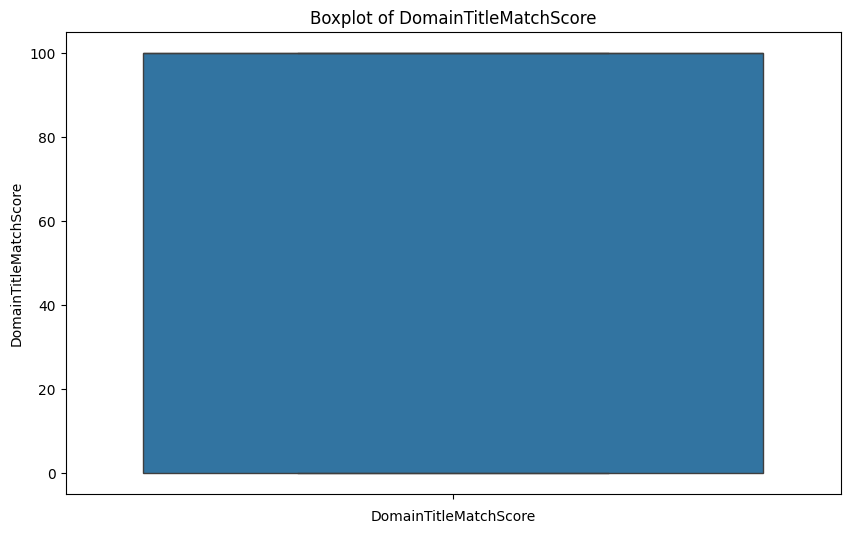

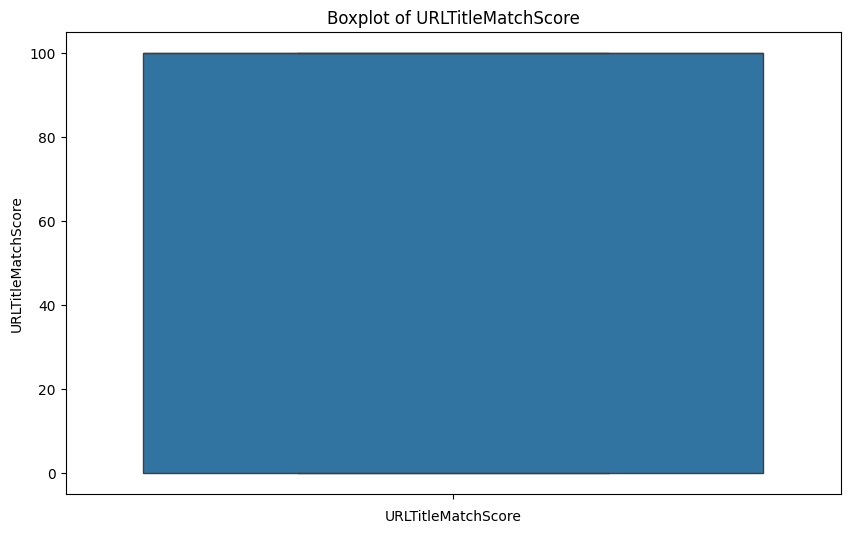

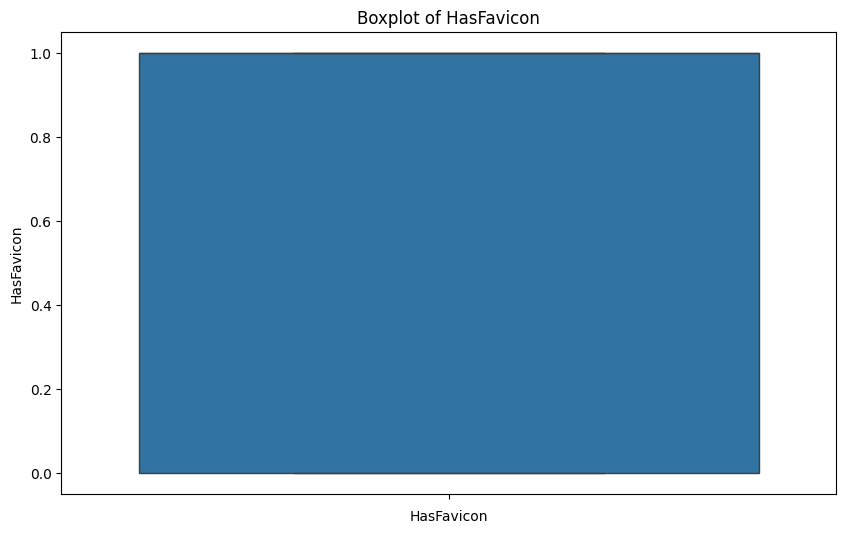

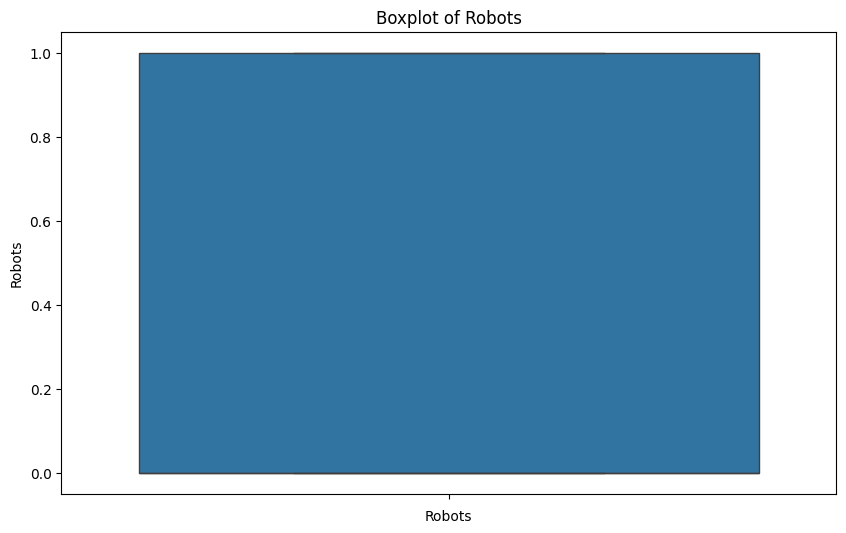

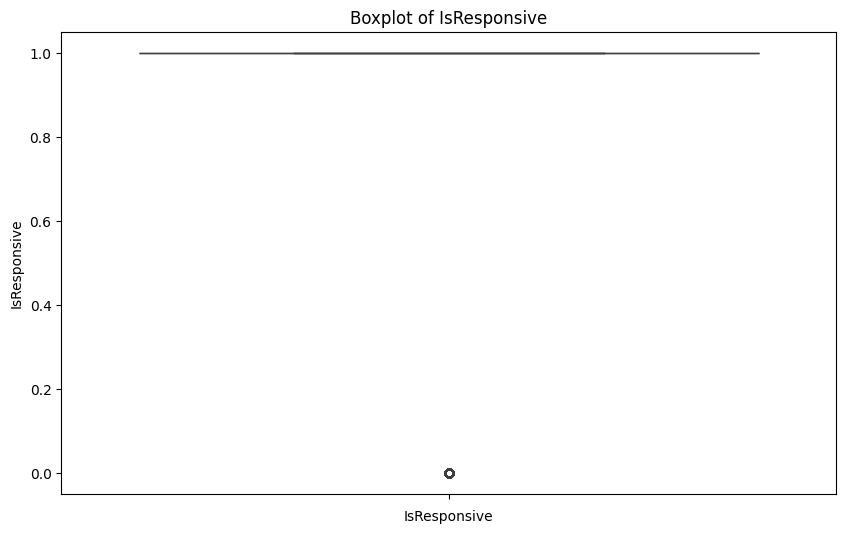

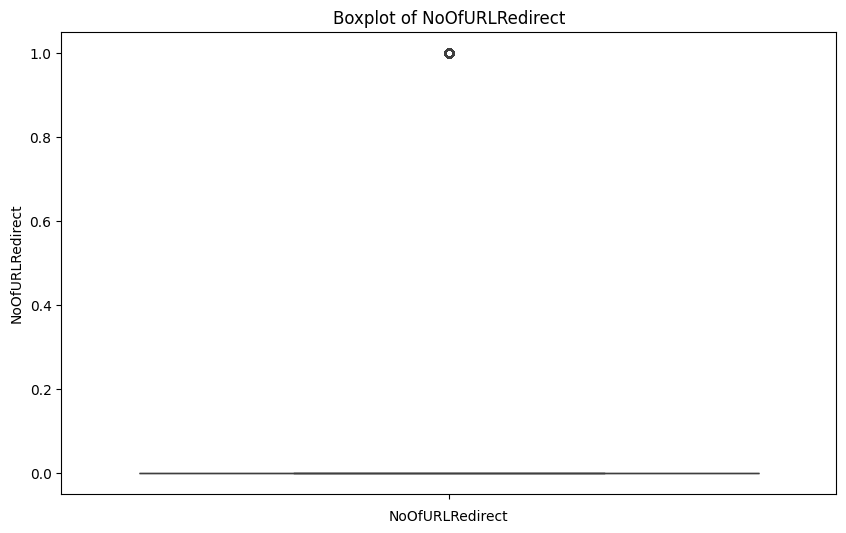

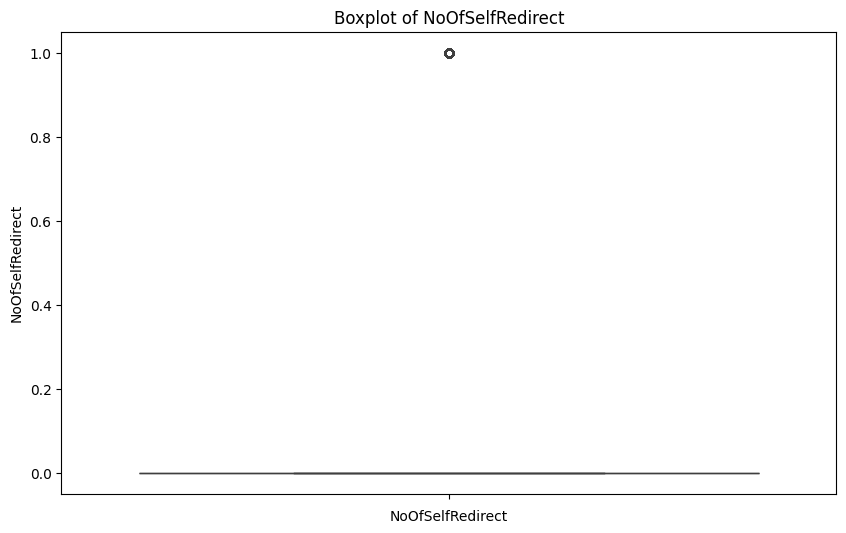

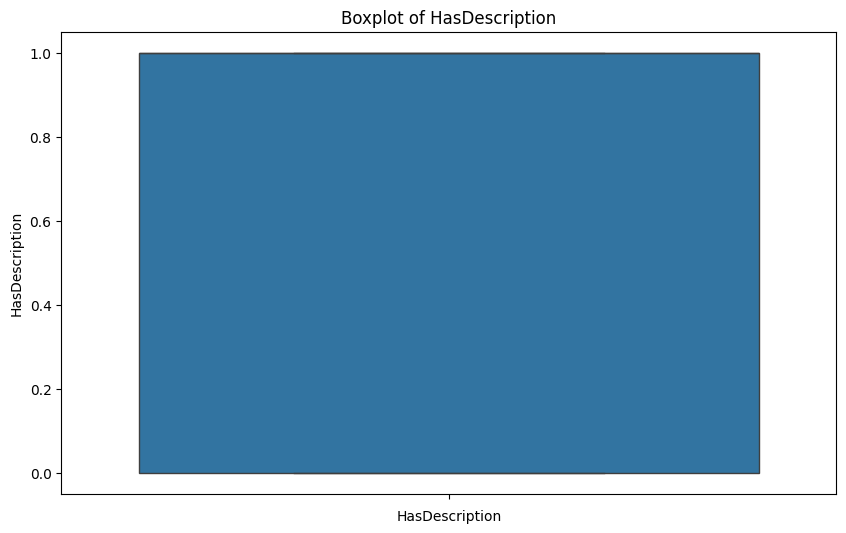

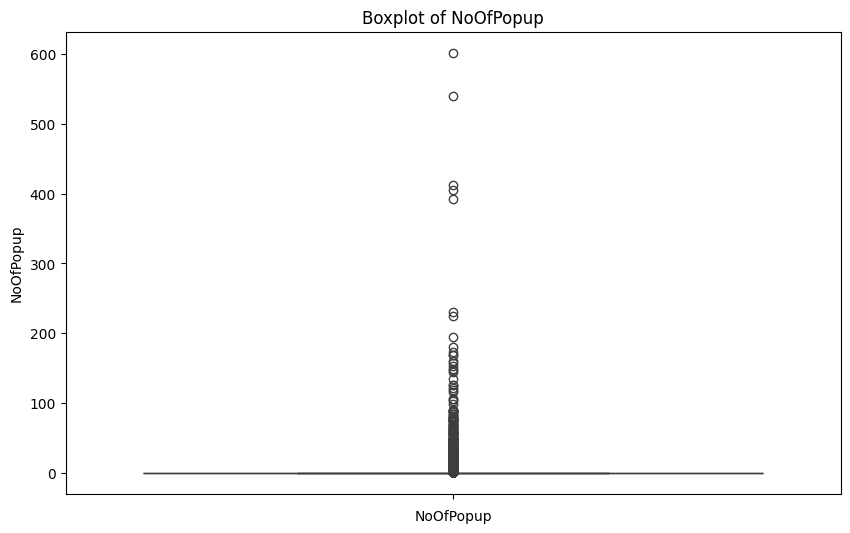

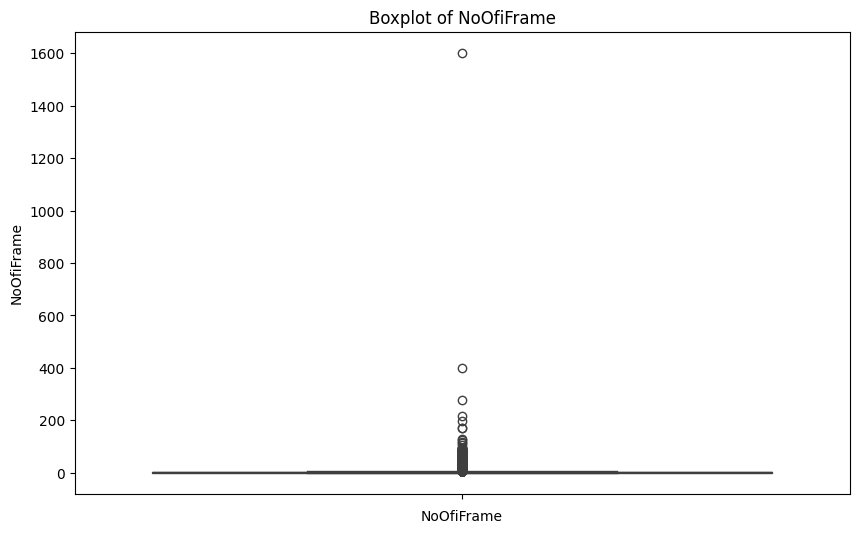

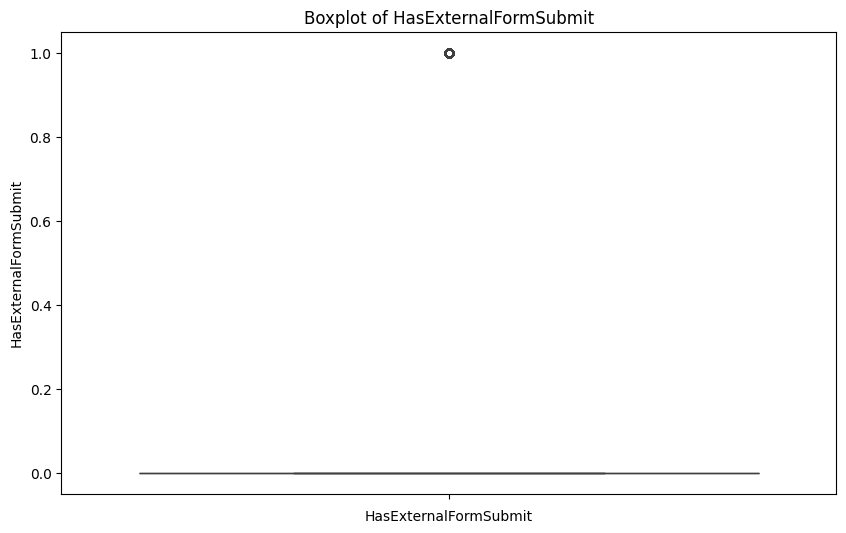

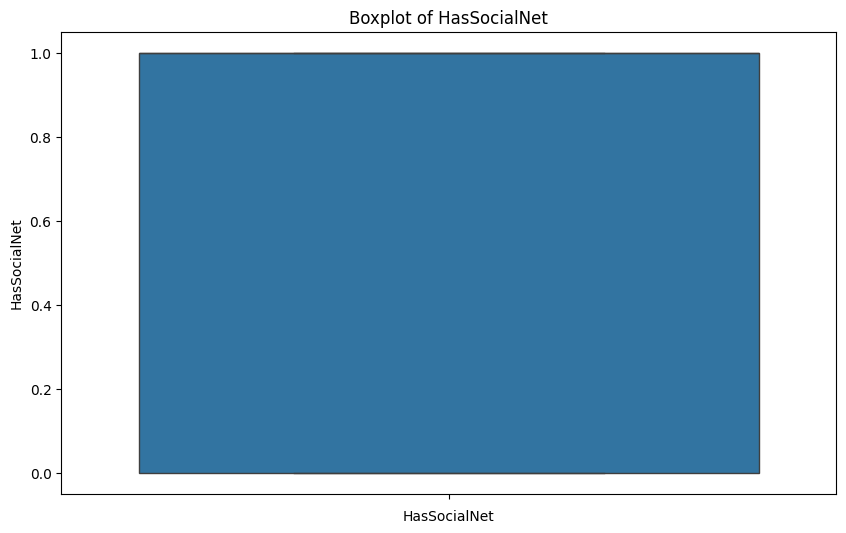

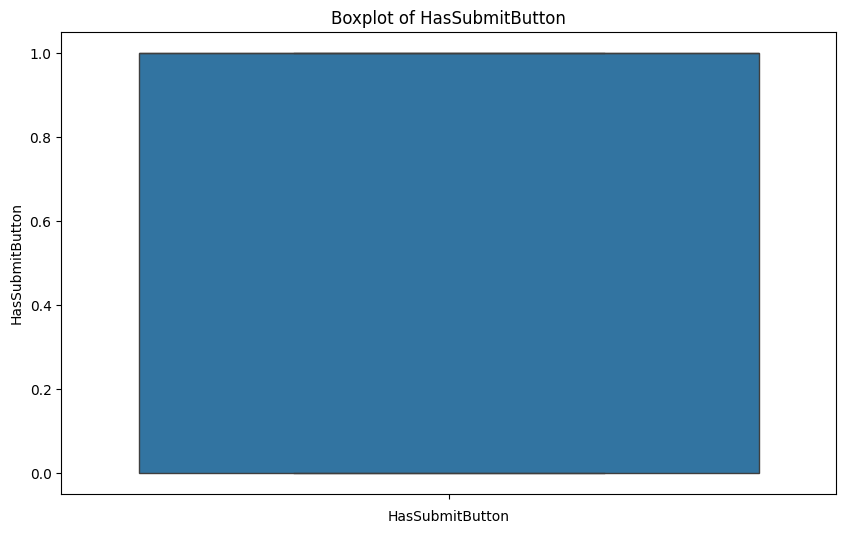

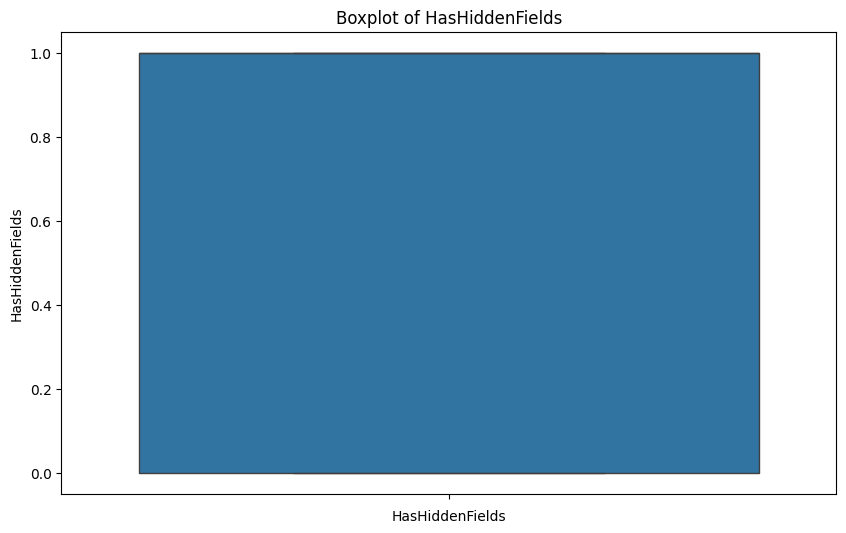

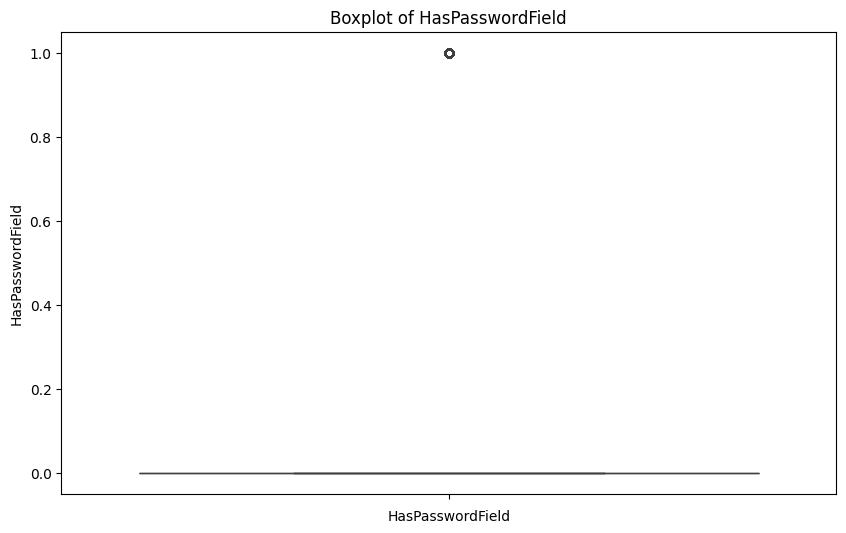

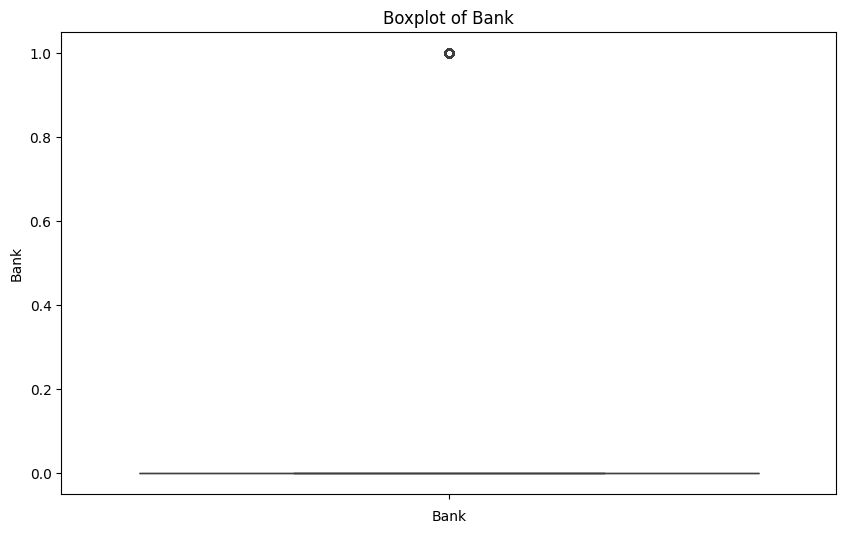

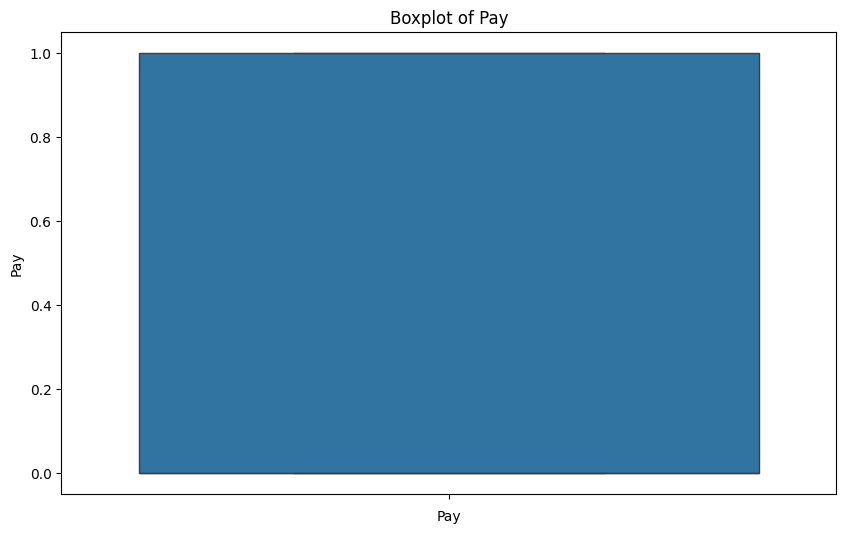

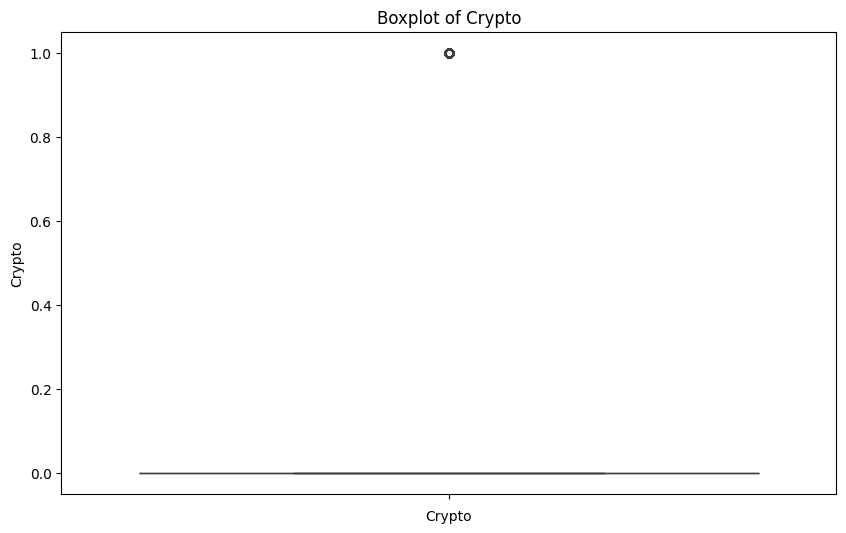

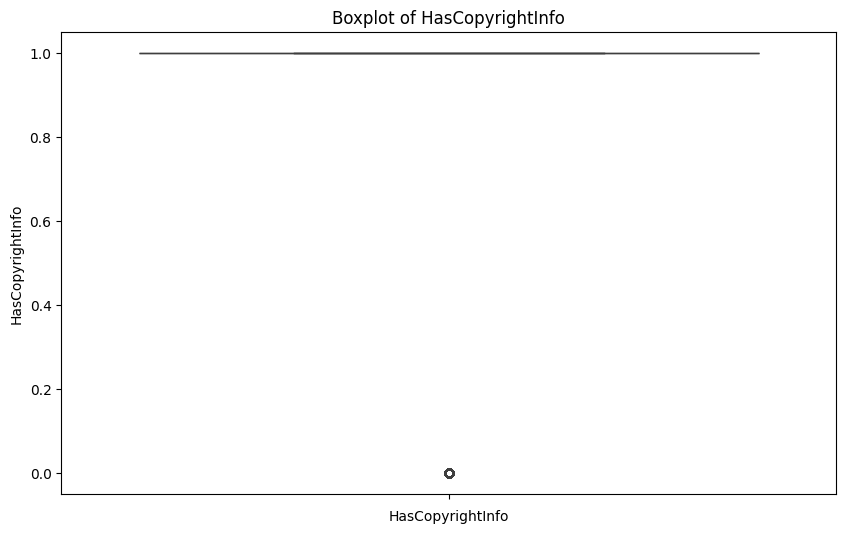

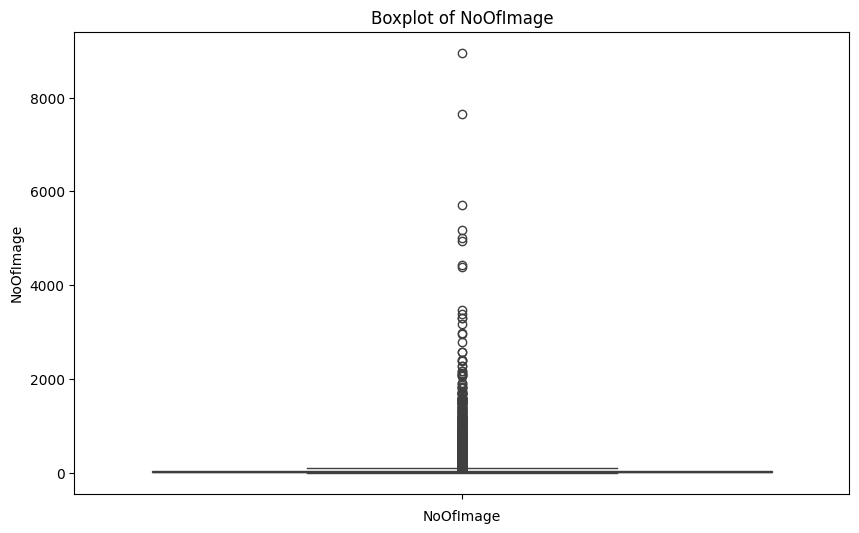

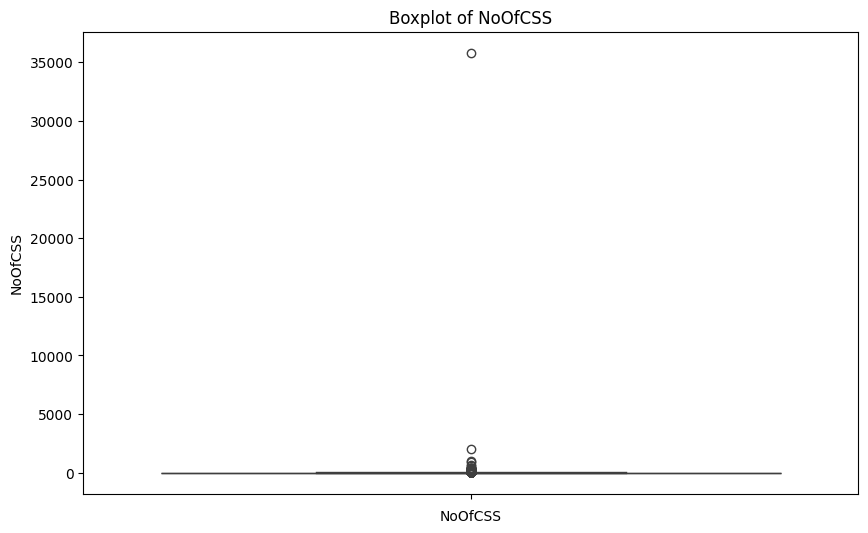

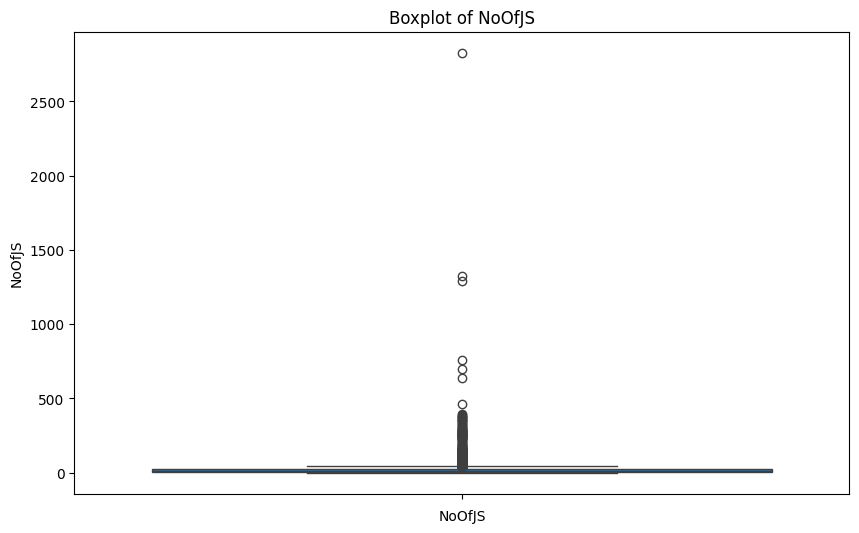

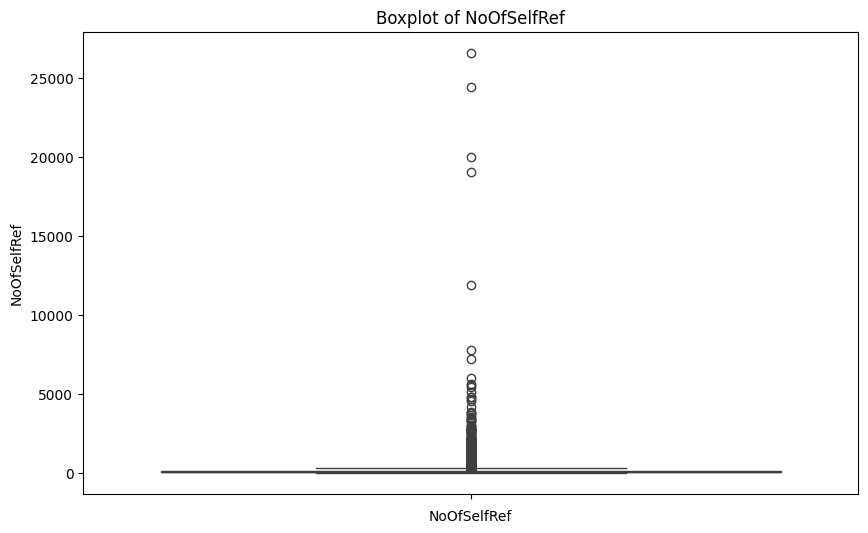

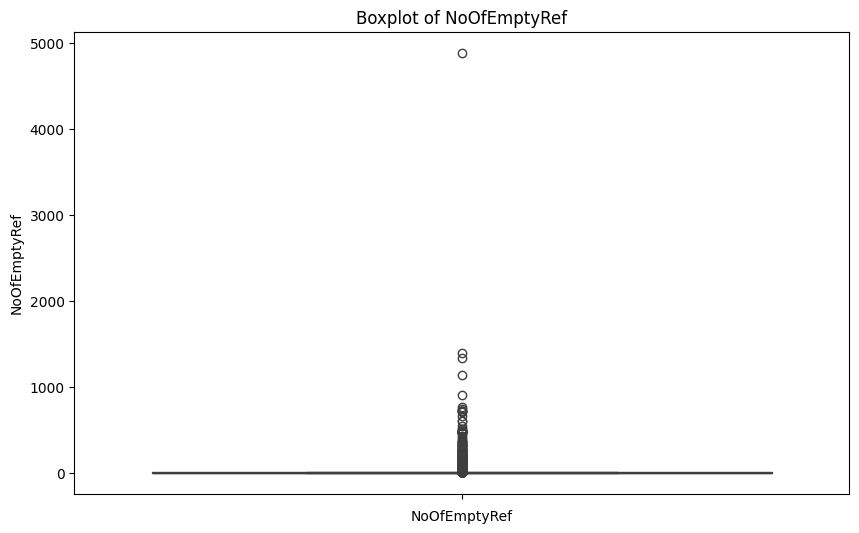

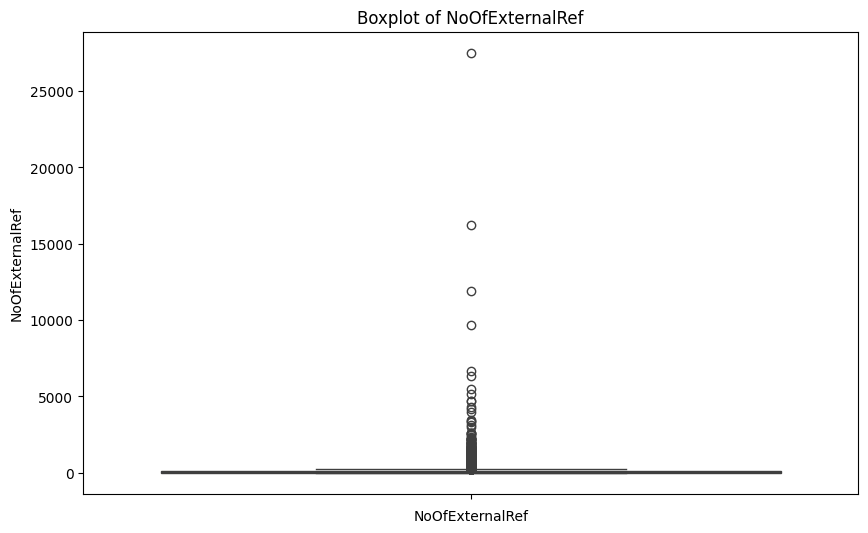

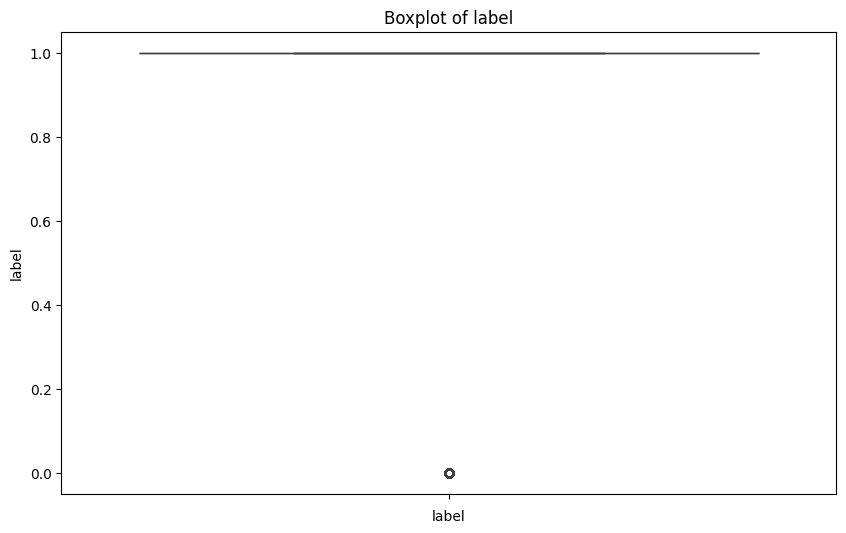

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Membuat boxplot untuk setiap kolom numerik
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [35]:
# print the number of duplicates
print(f"Number of duplicates in training set: {train_set.duplicated().sum()}")
print(f"Number of duplicates in validation set: {val_set.duplicated().sum()}")

Number of duplicates in training set: 0
Number of duplicates in validation set: 0


### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

# Binning DomainLength
bins = [0, 10, 50, 93]
labels = ['short', 'average', 'long']
df['DomainLength_Binned'] = pd.cut(df['DomainLength'], bins=bins, labels=labels)

# Data Normalization
class MinMaxScalerImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return self.scaler.transform(X)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()
threshold = 0.85

to_drop = set()
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j and abs(corr_matrix.loc[i, j]) > threshold:
            to_drop.add(i)

df.drop(columns=to_drop, inplace=True)

# VarianceThreshold
threshold = 0.01
numeric_df = df.select_dtypes(include='number')  # Select numeric columns again
selector = VarianceThreshold(threshold=threshold)
reduced_features = selector.fit_transform(numeric_df)

selected_columns = numeric_df.columns[selector.get_support()]
df = df[selected_columns]

print("Final DataFrame after feature selection:")
print(df.head())

Final DataFrame after feature selection:
   id  DomainLength  CharContinuationRate  TLDLegitimateProb  TLDLength  \
0   1          17.0              0.800000                NaN        NaN   
1   4           NaN              1.000000           0.000896        2.0   
2   5          28.0              0.857143                NaN        NaN   
3   6           NaN              0.562500           0.522907        NaN   
4  11          22.0              1.000000                NaN        NaN   

   NoOfSubDomain  LetterRatioInURL  NoOfDegitsInURL  NoOfEqualsInURL  \
0            2.0             0.417              0.0              0.0   
1            0.0             0.421              2.0              NaN   
2            2.0               NaN              0.0              0.0   
3            1.0               NaN              0.0              NaN   
4            1.0               NaN              0.0              NaN   

   NoOfAmpersandInURL  ...  Pay  Crypto  HasCopyrightInfo  NoOfImage  NoOfC

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [37]:
# Feature Scaling Class
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaling_method='standard'):
        self.scaling_method = scaling_method
        self.scaler = None

    def fit(self, X, y=None):
        self.numerical_columns = X.select_dtypes(include=[np.number]).columns

        if self.scaling_method == 'standard':
            self.scaler = StandardScaler()
        else:
            raise ValueError("Invalid scaling_method. Only 'standard' is supported.")

        self.scaler.fit(X[self.numerical_columns])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.numerical_columns] = self.scaler.transform(X[self.numerical_columns])
        return X_scaled

scaler = FeatureScaler(scaling_method='standard')
X_train_scaled = scaler.fit_transform(train_set)

Standardization digunakan untuk menyesuaikan skala fitur numerik sehingga semuanya memiliki rata-rata 0 dan standar deviasi 1. Ini penting untuk algoritma seperti KNN yang mengandalkan perhitungan jarak, agar semua fitur memberikan pengaruh yang setara. Meski Naive Bayes tidak terlalu bergantung pada skala, menggunakan Standardization dapat membantu jika data memiliki rentang nilai yang sangat berbeda, sehingga perhitungan probabilitas menjadi lebih stabil.

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [38]:
# Target Encoding Class
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means = {}

    def fit(self, X, y):
        self.target_means = {
            col: X.groupby(col)[y.name].mean()
            for col in X.select_dtypes(include=['object', 'category']).columns
        }
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col, mapping in self.target_means.items():
            X_encoded[col] = X_encoded[col].map(mapping).fillna(0)
        return X_encoded

encoder = TargetEncoder()
y_train = train_set['label']
X_train_encoded = encoder.fit(pd.DataFrame(train_set), y_train).transform(pd.DataFrame(X_train_scaled))

Target Encoding mengubah kategori menjadi angka dengan cara menggantinya dengan rata-rata target untuk setiap kategori. Hal ini membantu algoritma seperti KNN memahami informasi dari kategori saat menghitung jarak antar data. Untuk Naive Bayes, metode ini juga berguna karena menghasilkan angka yang lebih berguna tanpa menambah banyak kolom baru, seperti yang terjadi pada One-Hot Encoding.

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [39]:
class SMOTEHandler:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.smote = SMOTE(random_state=self.random_state)

    def fit_resample(self, X, y):
        return self.smote.fit_resample(X, y)

smote_handler = SMOTEHandler(random_state=42)
X_train_resampled, y_train_resampled = smote_handler.fit_resample(X_train_encoded, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


SMOTE (Synthetic Minority Oversampling Technique) membantu menyeimbangkan data dengan menambahkan contoh baru untuk kelas minoritas, sehingga data menjadi lebih rata. Pada KNN, ini membuat neighbor terdekat lebih representatif untuk kelas minoritas, dan meningkatkan akurasi prediksi. Untuk Naive Bayes, SMOTE membantu model memahami pola dari kelas minoritas dengan lebih baik, sehingga prediksi untuk kelas tersebut tidak kalah dengan kelas mayoritas.

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [43]:
# from sklearn.pipeline import Pipeline

# # Note: You can add or delete preprocessing components from this pipeline

# pipe = Pipeline([("imputer", FeatureImputer()),
#                  ("featurecreator", FeatureCreator()),
#                  ("scaler", FeatureScaler()),
#                  ("encoder", FeatureEncoder())])

# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

NameError: name 'FeatureImputer' is not defined

In [41]:
# # Your code should work up until this point
# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

or create your own here

In [42]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Check if train_set and val_set are DataFrames
if not isinstance(train_set, pd.DataFrame):
    train_set = pd.DataFrame(train_set)
if not isinstance(val_set, pd.DataFrame):
    val_set = pd.DataFrame(val_set)

# Define the pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # Impute missing values
    ("variance_threshold", VarianceThreshold()),   # Feature selection based on variance
    ("scaler", StandardScaler()),                    # Scaling features
    ("minmax", MinMaxScaler()),                       # Normalize features
    ("smote", SMOTE())                               # Resampling with SMOTE
])

# Fit the pipeline on the training data
pipe.fit(train_set, y_train)

# Transform the training and validation sets
X_train = pipe.transform(train_set)
X_val = pipe.transform(val_set)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Validation shapes: X={X_val.shape}, y={y_train.shape}")

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'https://www.tetleyusa.com'

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## A. KNN

In [ ]:
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# KNN From Scratch
class KNNScratch:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _calculate_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            p = 3  # Default value for Minkowski distance
            return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)
        else:
            raise ValueError("Unsupported metric. Choose 'euclidean', 'manhattan', or 'minkowski'.")

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = [self.y_train[i] for i in nearest_indices]
            predictions.append(np.bincount(nearest_labels).argmax())
        return np.array(predictions)

    def save_model(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(filepath):
        with open(filepath, 'rb') as f:
            return pickle.load(f)

# Load dataset from external source
df = pd.read_csv('https://drive.google.com/uc?id=1HMApjJesqeAiylfDkhz43vTpOndlmk9t')

# Convert non-numeric columns to numeric using one-hot encoding
if not all(df.drop(columns=['label']).applymap(np.isreal).all()):
    df = pd.get_dummies(df, columns=df.select_dtypes(include=['object', 'category']).columns)

# Split into train and validation sets
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

X_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values
X_val = val_df.drop(columns=['label']).values
y_val = val_df['label'].values

# KNN From Scratch Implementation
knn_scratch = KNNScratch(n_neighbors=5, metric='euclidean')
knn_scratch.fit(X_train, y_train)
y_pred_scratch = knn_scratch.predict(X_val)

# Evaluate KNN From Scratch
print("KNN From Scratch Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_scratch))
print("Classification Report:\n", classification_report(y_val, y_pred_scratch))

# Save and Load KNN From Scratch
knn_scratch.save_model('knn_scratch_model.pkl')
loaded_knn_scratch = KNNScratch.load_model('knn_scratch_model.pkl')
y_pred_loaded_scratch = loaded_knn_scratch.predict(X_val)
print("Loaded KNN From Scratch Accuracy:", accuracy_score(y_val, y_pred_loaded_scratch))

# KNN Scikit-Learn Implementation
knn_sklearn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_sklearn.fit(X_train, y_train)
y_pred_sklearn = knn_sklearn.predict(X_val)

# Evaluate KNN Scikit-Learn
print("KNN Scikit-Learn Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_sklearn))
print("Classification Report:\n", classification_report(y_val, y_pred_sklearn))

# Save and Load KNN Scikit-Learn Model
with open('knn_sklearn_model.pkl', 'wb') as f:
    pickle.dump(knn_sklearn, f)
with open('knn_sklearn_model.pkl', 'rb') as f:
    loaded_knn_sklearn = pickle.load(f)
y_pred_loaded_sklearn = loaded_knn_sklearn.predict(X_val)
print("Loaded KNN Scikit-Learn Accuracy:", accuracy_score(y_val, y_pred_loaded_sklearn))

## B. Naive Bayes

In [ ]:
# Importing necessary libraries for Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming `X_train`, `X_test`, `y_train`, `y_test` are preprocessed and defined

# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Fit the model to the training data
gnb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gnb.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)  # Ensure y_test is defined
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
from GaussianNaiveBayes import GaussianNaiveBayes
import numpy as np

# Assuming `X_train`, `X_test`, `y_train`, `y_test` are defined as numpy arrays

# Initialize the custom Gaussian Naive Bayes model
gnb = GaussianNaiveBayes()

# Fit the model to the training data
gnb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gnb.predict(X_test)

# Calculate the accuracy score
print(gnb.score(X_test, y_test))  # Call score() with the test data

## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [ ]:
# Type your code here

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

In [ ]:
# Type your code here



# 5. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`